# The life of an athlete with type 1 diabetes: descriptives

Descriptives for the 2019 training season of 12 TNN athletes

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
from copy import copy

from plot import *
from calc import glucose_levels_, mmoll_mgdl, mgdl_mmoll, timestamp_to_seconds, perc_in_level
from calc import stats_cgm as stat_func
from config import DATA_PATH, SAVE_PATH

In [2]:
SAVE_PATH = 'descriptives/'

for d in ('availability', 'hist', 'cdf', 'boxplot', 'time_in_zone', 'time_cycling', 'events'):
    if not os.path.exists(SAVE_PATH+'Dexcom/'+d):
        os.makedirs(SAVE_PATH+'Dexcom/'+d)
for d in ('availability',):
    if not os.path.exists(SAVE_PATH+'TrainingPeaks/'+d):
        os.makedirs(SAVE_PATH+'TrainingPeaks/'+d)

In [3]:
COL = 'Glucose Value (mg/dL)'

In [4]:
SECTIONS = ('wake', 'exercise', 'recovery', 'sleep')

## Data

### Read data

**Athlete characteristics**

In [5]:
info = pd.read_csv(DATA_PATH+'agg/info.csv')
info = info.reset_index()
info = info.rename(columns={'index':'RIDER'})
info

RIDER gender  nationality  age  diabetes_duration     weight      bf(%)  \
0       1      M  Switzerland   22                 11  60.500000   9.066667   
1       2      M        Italy   30                 14  71.633333   8.833333   
2       3      M      Ireland   26                  7  66.733333   6.566667   
3       4      M    Australia   19                  7  78.666667   9.433333   
4       5      M  Netherlands   25                  6  69.633333   7.700000   
5       6      M    Australia   20                  9  56.700000   4.950000   
6       7      M        Italy   22                  6  65.333333   8.066667   
7       8      M  New Zealand   20                 17  65.000000  11.900000   
8       9      M       France   23                 10  63.100000   8.533333   
9      10      M           UK   27                 17  75.466667   7.700000   
10     11      M  Netherlands   24                 15  70.700000   8.900000   
11     12      M        Spain   30                  8  64.000000   5.600000   
12     13      M      Hungary   34                  1  60.333333   4.866667   
13     14      M      Finland   27                 17  75.166667   9.333333   
14     15      M       France   25                 15  73.766667   7.200000   
15     16      M   Uzbekistan   22                 13  56.666667   9.466667   
16     17      M       France   22                  4        NaN        NaN   
17     18      M           US   26                  2        NaN        NaN   

    HbA1c         FTP        LTHR       HRmax     VO2max  height  
0     6.7  307.000000  176.333333  192.333333  68.888889   174.0  
1     6.6  326.000000  168.666667  181.666667  66.915285   178.0  
2     6.8  298.000000  171.000000  180.000000  66.666164   171.0  
3     7.8  356.000000  170.333333  187.333333  67.333333   178.0  
4     6.5  341.000000  179.666667  192.666667  72.857143   183.0  
5     6.4  298.500000  173.000000  184.500000  70.781588   169.0  
6     5.9  298.500000  171.500000  180.500000  72.203125   167.0  
7     7.7  292.000000  187.000000  204.000000  64.000000   165.0  
8     7.2  278.666667  182.333333  195.000000  67.522310   173.0  
9     7.3  377.333333  177.000000  194.333333  73.982571   185.0  
10    6.4  317.000000  175.000000  190.000000  65.000000   179.0  
11    6.0  347.000000  158.333333  178.666667  75.937500   178.0  
12    6.3  345.666667  173.000000  182.333333  76.666667   179.0  
13    7.1  348.000000  169.000000  189.500000  66.500000   187.0  
14    6.4  389.000000  185.000000  198.000000  66.000000   179.0  
15    6.6  283.333333  125.610000  200.333333  74.678571   170.0  
16    NaN         NaN         NaN         NaN        NaN   167.0  
17    NaN         NaN         NaN         NaN        NaN   180.0

**Blood tests**

In [6]:
hba1c = pd.read_csv(DATA_PATH+'bloodtests/HbA1c.csv', header=[0,1,2], index_col=[0])
hba1c = hba1c.mean(level=0, axis=1) # calc mean over seasons
hba1c = hba1c.reset_index()
hba1c

RIDER      2018      2019
0       1       NaN  6.333333
1       2  7.200000  6.533333
2       3  7.100000  6.850000
3       4       NaN  8.000000
4       5  6.800000  6.725000
5       6       NaN  6.550000
6       7  6.825000  6.366667
7       9  7.075000  7.025000
8      10  6.833333  7.233333
9      12  6.025000  5.950000
10     13       NaN  6.366667
11     14  7.650000  6.925000
12     15  6.775000  6.525000
13     16       NaN  6.825000

**Professional**

In [7]:
pro = pd.read_csv(DATA_PATH+'info/pro.csv')
pro = pro.sort_values('RIDER')

Select only people for whom we have *ethics*

In [8]:
pro = pro[pro.ethics == 1]
pro = pro.drop('ethics', axis=1)

# anonymize file
pro = pro.drop('name', axis=1)
pro['RIDER'] = pro['RIDER'].astype(int)
pro = pro.reset_index(drop=True)

pro

RIDER 2014 2015 2016 2017 2018 2019 2020 2021
0       1    -    -    -  DEV  DEV  PRO  PRO  PRO
1       2  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
2       3  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
3       4    -    -    -  DEV  PRO  PRO  PRO  PRO
4       5    -  PRO  PRO  PRO  PRO  PRO  PRO  PRO
5       6    -    -    -  DEV  DEV  PRO  PRO  PRO
6       7    -    -  DEV  PRO  PRO  PRO  PRO  PRO
7       8    -    -    -  DEV  DEV  DEV  PRO  PRO
8       9    -    -    -  PRO  PRO  PRO  PRO  PRO
9      10    -    -  DEV  DEV  PRO  PRO  PRO  PRO
10     11    -  PRO  PRO  PRO    -  DEV  PRO  PRO
11     12  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
12     13    -    -    -    -    -  PRO  PRO  PRO
13     14  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
14     15  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
15     16    -    -    -  DEV  DEV  PRO  PRO  DEV
16     17    -    -    -    -    -    -    -    -
17     18    -    -    -  DEV  DEV  DEV  DEV  PRO

**Season dates**

In [9]:
season = pd.read_csv(DATA_PATH+'calendar/season_dates.csv', index_col=[0,1], header=[0,1])
season = season.reset_index().drop('level_1', axis=1)
season = season.rename(columns={'level_0':'RIDER'})
season

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER        2015                    2016                    2017  \
               start         end       start         end       start   
0      1         NaN         NaN         NaN         NaN  2016-12-06   
1      2  2014-11-17  2015-10-18  2015-11-24  2016-10-28  2016-11-15   
2      3  2014-11-06  2015-10-18  2015-11-06  2016-10-23  2016-12-06   
3      4         NaN         NaN         NaN         NaN  2016-11-15   
4      5  2014-11-14  2015-11-08  2015-11-27  2016-10-30  2016-11-12   
5      6         NaN         NaN         NaN         NaN  2016-12-12   
6      7         NaN         NaN  2015-10-07  2016-04-16  2016-11-07   
7      8         NaN         NaN         NaN         NaN  2016-12-14   
8      9         NaN         NaN         NaN         NaN  2016-12-06   
9     10         NaN         NaN  2015-11-06  2016-10-17  2016-11-04   
10    11  2014-11-02  2015-11-12  2015-12-01  2016-11-12  2016-12-07   
11    12  2014-11-15  2015-10-29  2015-11-24  2016-10-22  2016-11-07   
12    13         NaN         NaN         NaN         NaN         NaN   
13    14  2014-11-14  2015-10-25  2015-12-02  2016-10-30  2016-11-13   
14    15  2014-11-17  2015-10-18  2015-11-12  2016-10-23  2016-11-14   
15    16         NaN         NaN         NaN         NaN  2016-12-14   
16    17         NaN         NaN         NaN         NaN         NaN   
17    18         NaN         NaN         NaN         NaN  2016-12-13   

                      2018                    2019                    2020  \
           end       start         end       start         end       start   
0   2017-11-05  2017-11-13  2018-10-20  2018-11-05  2019-10-20  2019-11-04   
1   2017-09-11  2017-10-23  2018-10-02  2018-10-23  2019-10-16  2019-11-04   
2   2017-10-05  2017-11-13  2018-10-31  2018-11-19  2019-10-20  2019-11-13   
3   2017-09-30  2017-10-05  2018-11-01  2018-11-12  2019-10-16  2019-11-04   
4   2017-09-23  2017-10-03  2018-10-17  2018-11-12  2019-10-20  2019-11-11   
5   2017-10-14  2017-10-30  2018-10-25  2018-12-01  2019-10-01  2019-10-21   
6   2017-11-05  2017-11-28  2018-10-17  2018-11-29  2019-10-27  2019-12-02   
7   2017-11-05  2017-11-19  2018-12-12  2018-12-24  2019-10-16  2019-10-24   
8   2017-11-05  2017-11-20  2018-09-24  2018-11-05  2019-09-23  2019-10-14   
9   2017-11-12  2017-11-27  2018-11-10  2018-11-22  2019-10-28  2019-11-11   
10  2017-10-22         NaN         NaN  2018-10-15  2019-06-23  2019-10-23   
11  2017-10-31  2017-11-06  2018-11-11  2018-11-26  2019-11-05  2019-11-18   
12         NaN         NaN         NaN  2018-12-12  2019-10-20  2019-11-18   
13  2017-11-20  2017-12-21  2018-11-01  2018-11-12  2019-09-09  2019-10-21   
14  2017-11-01  2017-11-27  2018-10-21  2018-11-12  2019-10-20  2019-11-09   
15  2017-09-10  2017-11-21  2018-11-02  2018-11-19  2019-09-29  2019-11-14   
16         NaN         NaN         NaN         NaN         NaN         NaN   
17  2017-10-22  2017-11-20  2018-08-12  2018-10-22  2019-10-13  2019-11-09   

                      2021              
           end       start         end  
0   2020-09-23  2020-10-08  2021-10-30  
1   2020-10-11  2020-11-09  2021-10-04  
2   2020-10-16  2020-11-16  2021-10-03  
3   2020-10-28  2020-11-16  2021-08-14  
4   2020-10-31  2020-11-16  2021-08-31  
5   2020-07-17  2020-11-01  2021-09-03  
6   2020-10-12  2020-11-09  2021-09-30  
7   2020-09-27  2020-11-01  2021-10-03  
8   2020-10-12  2020-11-05  2021-10-01  
9   2020-10-11  2020-11-16  2021-10-17  
10  2020-10-02  2020-11-01  2021-09-17  
11  2020-10-08  2020-11-01  2021-09-03  
12  2020-10-11  2020-11-16  2021-09-05  
13  2020-10-12  2020-11-02  2021-09-20  
14  2020-10-15  2020-11-07  2021-10-29  
15  2020-10-31  2020-11-23  2021-09-30  
16         NaN         NaN         NaN  
17  2020-10-18  2020-11-11  2021-10-05

**TrainingPeaks (aggregated)**

In [10]:
tp_agg = pd.read_csv(DATA_PATH+'agg/trainingpeaks_day.csv', index_col=[0,1], header=[0,1])
tp_agg = tp_agg.reset_index()
tp_agg['date'] = pd.to_datetime(tp_agg['date'])
tp_agg

RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                                                CALENDAR                      \
       local_timestamp_max file_id_unique_count     race travel race_3d_mean   
0      2016-11-22 15:15:40                  1.0    False   True          0.0   
1      2016-11-23 16:35:14                  1.0    False  False          0.0   
2      2016-11-24 16:56:38                  2.0    False  False          0.0   
3      2016-11-26 12:12:52                  1.0    False  False          0.0   
4      2016-12-06 16:11:38                  2.0    False  False          0.0   
...                    ...                  ...      ...    ...          ...   
30207  2021-11-18 16:19:15                  1.0    False  False          0.0   
30208  2021-11-25 12:54:14                  1.0    False  False          0.0   
30209  2021-11-26 12:39:08                  1.0    False  False          0.0   
30210  2021-11-27 14:36:43                  1.0    False  False          0.0   
30211  2021-11-28 14:21:57                  1.0    False  False          0.0   

                    ...                LOC                     \
      race_7d_mean  ... vertical_speed_min vertical_speed_max   
0              0.0  ...                NaN                NaN   
1              0.0  ...                NaN                NaN   
2              0.0  ...                NaN                NaN   
3              0.0  ...                NaN                NaN   
4              0.0  ...                NaN                NaN   
...            ...  ...                ...                ...   
30207          0.0  ...                NaN                NaN   
30208          0.0  ...                NaN                NaN   
30209          0.0  ...                NaN                NaN   
30210          0.0  ...                NaN                NaN   
30211          0.0  ...                NaN                NaN   

                                                                     \
      vertical_speed_sum vertical_speed_energy vertical_speed_peaks   
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
...                  ...                   ...                  ...   
30207                NaN                   NaN                  NaN   
30208                NaN                   NaN                  NaN   
30209                NaN                   NaN                  NaN   
30210                NaN                   NaN                  NaN   
30211                NaN                   NaN                  NaN   

                                                                              \
      vertical_speed_rms distance_up_iqr vertical_speed_iqr acceleration_iqr   
0                    NaN             NaN                NaN              NaN   
1                    NaN             NaN                NaN              NaN   
2                    NaN             NaN               

**Dexcom (aggregated)**

In [11]:
dc_agg = pd.read_csv(DATA_PATH+'agg/dexcom_day.csv')

dc_agg['date'] = pd.to_datetime(dc_agg['date'])

dc_agg = dc_agg.dropna(subset=['glucose_mean_'+i for i in ('exercise', 'recovery', 'sleep', 'wake')], how='all')
dc_agg = dc_agg.reset_index(drop=True)
dc_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (51,52) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


RIDER       date  time_in_hypo_day  time_in_hypoL2_day  \
0          1 2017-09-12                 0                   0   
1          1 2017-09-13                 0                   0   
2          1 2017-09-14                 7                   0   
3          1 2017-09-15                17                   0   
4          1 2017-09-16                10                   1   
...      ...        ...               ...                 ...   
11803      9 2020-02-11                 0                   0   
11804      9 2020-02-12                 1                   0   
11805      9 2020-02-13                 1                   0   
11806      9 2020-07-23                 0                   0   
11807      9 2020-07-24                 0                   0   

       time_in_hypoL1_day  time_in_target_day  time_in_hyper_day  \
0                       0                 130                 30   
1                       0                 203                 85   
2                       7                 247                 46   
3                      17                 254                 17   
4                       9                 189                 22   
...                   ...                 ...                ...   
11803                   0                 149                111   
11804                   1                 199                 33   
11805                   1                 117                  8   
11806                   0                   0                  1   
11807                   0                   7                  5   

       time_in_hyperL1_day  time_in_hyperL2_day  perc_in_hypo_day  ...  \
0                       30                    0          0.000000  ...   
1                       68                   17          0.000000  ...   
2                       46                    0          2.333333  ...   
3                       17                    0          5.902778  ...   
4                       22                    0          4.524887  ...   
...                    ...                  ...               ...  ...   
11803                  106                    5          0.000000  ...   
11804                   25                    8          0.429185  ...   
11805                    8                    0          0.793651  ...   
11806                    1                    0          0.000000  ...   
11807                    5                    0          0.000000  ...   

       count_sleep  LBGI_sleep  HBGI_sleep  AUC_sleep  hypo_sleep  \
0             72.0    0.000000    2.233929    10130.5       False   
1             72.0    1.006374    0.007478     6910.0       False   
2             72.0    1.302753    0.001658     6824.5       False   
3             72.0    0.000000    1.007591     9408.5       False   
4             72.0    1.190592    0.000083     6808.0       False   
...            ...         ...         ...        ...         ...   
11803         72.0    0.462046    6.585822    11036.7       False   
11804         72.0    0.009297    1.769761     9824.4       False   
11805          0.0    0.000000    0.000000        NaN       False   
11806          0.0    0.000000    0.000000        NaN       False   
11807          0.0    0.000000    0.000000        NaN       False   

       hyper_sleep  race_day  travel_day  exercise_day  completeness  
0            False     False       False          True      0.555556  
1            False     False       False          True      1.000000  
2            False     False       False          True      1.000000  
3            False     False        True          True      1.000000  
4            False     False       False          True      0.767361  
...            ...       ...         ...           ...           ...  
11803         True     False       False         False      0.902778  
11804        False     False       False          True      0.809028  
11805        False     False       False          Tr

**Dexcom (full)**

In [12]:
# TODO: check if we still need this cell!!
dc = pd.read_csv(DATA_PATH+'agg/dexcom.csv')

dc['timestamp'] = pd.to_datetime(dc['timestamp'])
dc['local_timestamp'] = pd.to_datetime(dc['local_timestamp'])

dc['date'] = pd.to_datetime(dc['date'])
dc

RIDER           timestamp  Glucose Value (mg/dL)  \
0             1 2014-01-01 00:00:00                    NaN   
1             1 2014-01-01 00:05:00                    NaN   
2             1 2014-01-01 00:10:00                    NaN   
3             1 2014-01-01 00:15:00                    NaN   
4             1 2014-01-01 00:20:00                    NaN   
...         ...                 ...                    ...   
15147643     18 2021-12-31 23:35:00                    NaN   
15147644     18 2021-12-31 23:40:00                    NaN   
15147645     18 2021-12-31 23:45:00                    NaN   
15147646     18 2021-12-31 23:50:00                    NaN   
15147647     18 2021-12-31 23:55:00                    NaN   

             local_timestamp  exercise  recovery   wake  sleep       date  \
0        2013-12-31 20:00:00     False     False   True  False 2013-12-31   
1        2013-12-31 20:05:00     False     False   True  False 2013-12-31   
2        2013-12-31 20:10:00     False     False   True  False 2013-12-31   
3        2013-12-31 20:15:00     False     False   True  False 2013-12-31   
4        2013-12-31 20:20:00     False     False   True  False 2013-12-31   
...                      ...       ...       ...    ...    ...        ...   
15147643 2022-01-01 00:35:00     False     False  False   True 2021-12-31   
15147644 2022-01-01 00:40:00     False     False  False   True 2021-12-31   
15147645 2022-01-01 00:45:00     False     False  False   True 2021-12-31   
15147646 2022-01-01 00:50:00     False     False  False   True 2021-12-31   
15147647 2022-01-01 00:55:00     False     False  False   True 2021-12-31   

          race_day  travel_day  exercise_day   hypo  hyper  glucose_rate  \
0            False       False         False  False  False           NaN   
1            False       False         False  False  False           NaN   
2            False       False         False  False  False           NaN   
3            False       False         False  False  False           NaN   
4            False       False         False  False  False           NaN   
...            ...         ...           ...    ...    ...           ...   
15147643     False       False         False  False  False           NaN   
15147644     False       False         False  False  False           NaN   
15147645     False       False         False  False  False           NaN   
15147646     False       False         False  False  False           NaN   
15147647     False       False         False  False  False           NaN   

          completeness  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  
...                ...  
15147643           0.0  
15147644           0.0  
15147645           0.0  
15147646           0.0  
15147647           0.0  

[15146832 rows x 16 columns]

### Plot data availability

In [13]:
dc_avail = dc_agg.pivot(index='RIDER', columns='date', values='completeness_day')

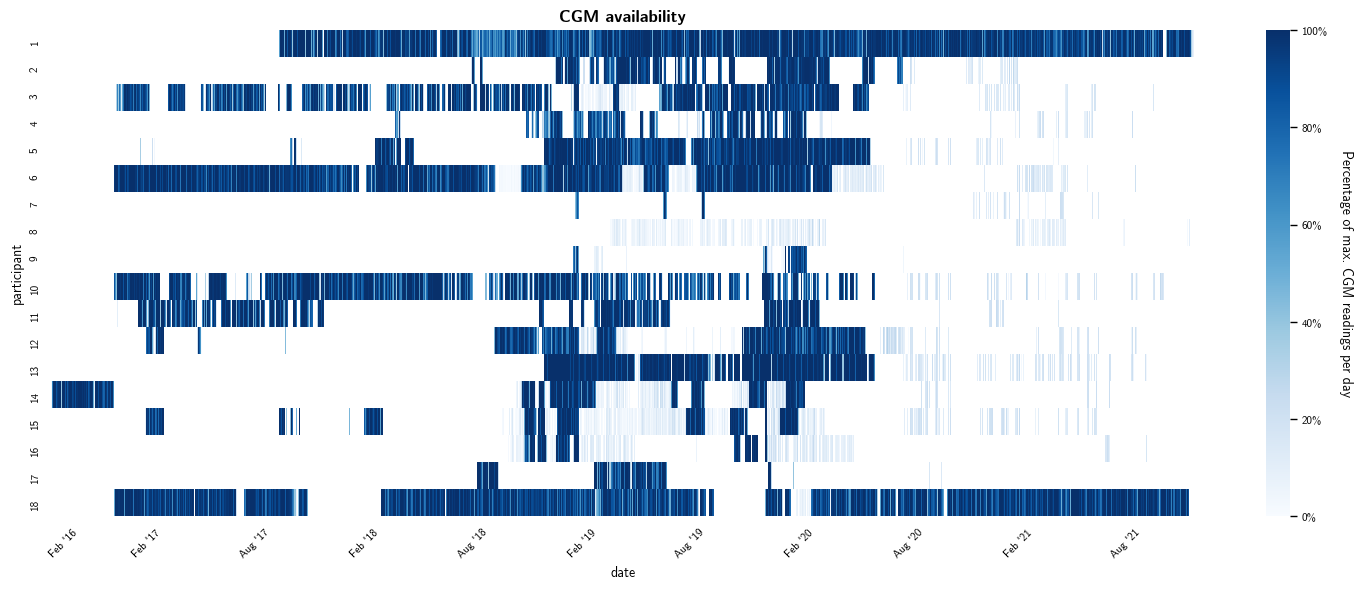

In [14]:
ax = plot_availability(dc_avail, rot_months=45, itv_months=6)
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_all', yticks=ax)

In [15]:
pro_list = pro.set_index('RIDER').stack().replace({'-':'np.nan'}).reset_index().rename(columns={'level_1':'year', 0:'pro'})
pro_list['year'] = pro_list['year'].astype(int)
pro_list.columns = pd.MultiIndex.from_product([pro_list.columns, ['']])
pro_list

RIDER  year     pro
                       
0       1  2014  np.nan
1       1  2015  np.nan
2       1  2016  np.nan
3       1  2017     DEV
4       1  2018     DEV
..    ...   ...     ...
139    18  2017     DEV
140    18  2018     DEV
141    18  2019     DEV
142    18  2020     DEV
143    18  2021     PRO

[144 rows x 3 columns]

In [16]:
tp_agg['year'] = tp_agg['date'].dt.year
tp_agg = pd.merge(tp_agg, pro_list, on=['RIDER', 'year'], how='left')
tp_agg = tp_agg.drop([('year')], axis=1)
tp_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                                                CALENDAR                      \
       local_timestamp_max file_id_unique_count     race travel race_3d_mean   
0      2016-11-22 15:15:40                  1.0    False   True          0.0   
1      2016-11-23 16:35:14                  1.0    False  False          0.0   
2      2016-11-24 16:56:38                  2.0    False  False          0.0   
3      2016-11-26 12:12:52                  1.0    False  False          0.0   
4      2016-12-06 16:11:38                  2.0    False  False          0.0   
...                    ...                  ...      ...    ...          ...   
30207  2021-11-18 16:19:15                  1.0    False  False          0.0   
30208  2021-11-25 12:54:14                  1.0    False  False          0.0   
30209  2021-11-26 12:39:08                  1.0    False  False          0.0   
30210  2021-11-27 14:36:43                  1.0    False  False          0.0   
30211  2021-11-28 14:21:57                  1.0    False  False          0.0   

                    ...                LOC                     \
      race_7d_mean  ... vertical_speed_max vertical_speed_sum   
0              0.0  ...                NaN                NaN   
1              0.0  ...                NaN                NaN   
2              0.0  ...                NaN                NaN   
3              0.0  ...                NaN                NaN   
4              0.0  ...                NaN                NaN   
...            ...  ...                ...                ...   
30207          0.0  ...                NaN                NaN   
30208          0.0  ...                NaN                NaN   
30209          0.0  ...                NaN                NaN   
30210          0.0  ...                NaN                NaN   
30211          0.0  ...                NaN                NaN   

                                                                     \
      vertical_speed_energy vertical_speed_peaks vertical_speed_rms   
0                       NaN                  NaN                NaN   
1                       NaN                  NaN                NaN   
2                       NaN                  NaN                NaN   
3                       NaN                  NaN                NaN   
4                       NaN                  NaN                NaN   
...                     ...                  ...                ...   
30207                   NaN                  NaN                NaN   
30208                   NaN                  NaN                NaN   
30209                   NaN                  NaN                NaN   
30210                   NaN                  NaN                NaN   
30211                   NaN                  NaN                NaN   

                                                                              \
      distance_up_iqr vertical_speed_iqr acceleration_iqr elevation_gain_iqr   
0                 NaN                NaN              NaN                NaN   
1                 NaN                NaN              NaN                NaN   
2                 NaN                NaN              N

In [17]:
tp_avail = tp_agg.pivot(index='RIDER', columns='date', values='pro')
tp_avail = tp_avail.replace({'PRO':2, 'DEV':1, 'np.nan':np.nan})

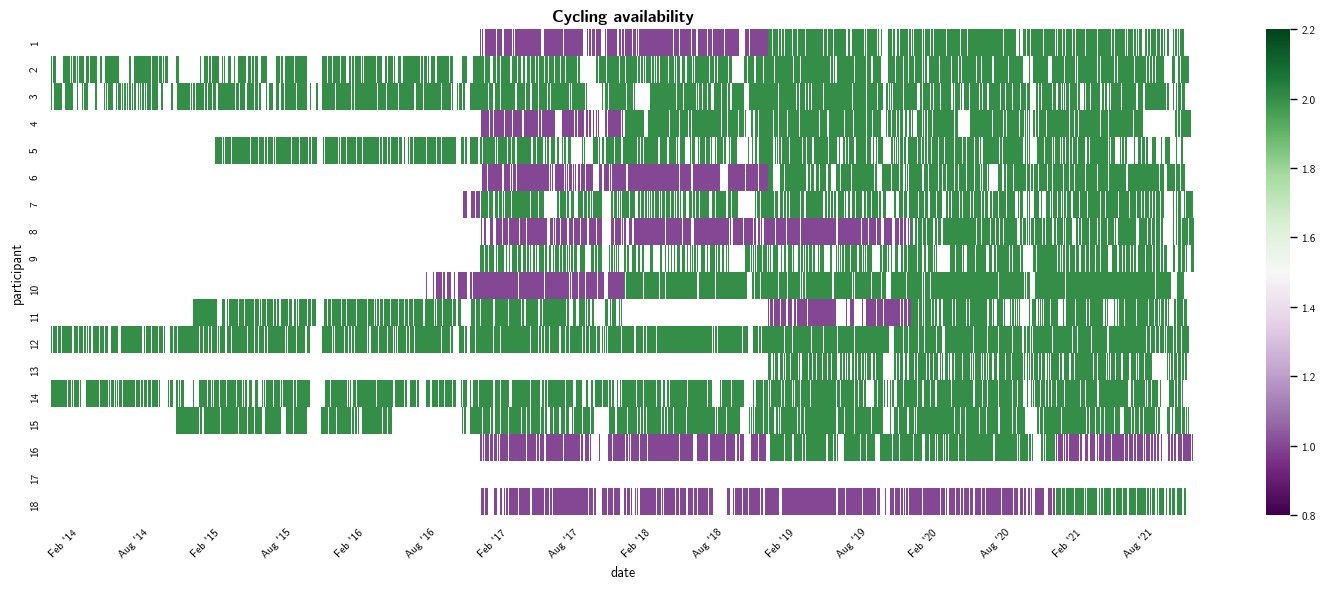

In [18]:
ax = plot_availability(tp_avail, cmap='PRGn', vmin=0.8, vmax=2.2, 
                       rot_months=45, itv_months=6, plot_colorbar=False)
plt.title('Cycling availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_all', dtype='TrainingPeaks', yticks=ax)

In [19]:
tp_agg = tp_agg.drop('pro', axis=1)

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [20]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))#.dropna(subset=['glucose_mean_day'])))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc.dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 18 ; D = 30212
Dexcom (agg): N = 18 ; D = 11808
Dexcom: N = 18 ; D = 11808


### Select data

#### Select riders that were pro in 2019

In [21]:
ATHLETES = pro.loc[pro['2019'] == 'PRO', 'RIDER'].to_list()

In [22]:
info = info[info.RIDER.isin(ATHLETES)].set_index('RIDER')
season = season[season.RIDER.isin(ATHLETES)].set_index('RIDER')
hba1c = hba1c[hba1c.RIDER.isin(ATHLETES)].set_index('RIDER')

In [23]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)]))
print("Dexcom (agg): N =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)]))
print("Dexcom: N =", len(dc[dc.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc[dc.RIDER.isin(ATHLETES)].dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 25116
Dexcom (agg): N = 14 ; D = 9246
Dexcom: N = 14 ; D = 9246


#### Select beginning and end of the training season in 2019

In [24]:
hba1c = hba1c['2019']
hba1c.name = 'HbA1c'

In [25]:
# merge 
info = info.drop('HbA1c', axis=1)
info = pd.merge(info, hba1c, left_index=True, right_index=True, how='left')

In [26]:
season = season['2019']

season['start'] = pd.to_datetime(season['start'])
season['end'] = pd.to_datetime(season['end'])

season_list = season.apply(lambda x: pd.date_range(x[0], x[1], freq='1D'), axis=1)\
    .apply(pd.Series).stack().reset_index().drop('level_1', axis=1).rename(columns={0:'date'})
season_list

RIDER       date
0         1 2018-11-05
1         1 2018-11-06
2         1 2018-11-07
3         1 2018-11-08
4         1 2018-11-09
...     ...        ...
4642     16 2019-09-25
4643     16 2019-09-26
4644     16 2019-09-27
4645     16 2019-09-28
4646     16 2019-09-29

[4647 rows x 2 columns]

In [27]:
tp_agg = pd.merge(tp_agg, season_list, how='inner', on=['RIDER', 'date'])
dc_agg = pd.merge(dc_agg, season_list, how='inner', on=['RIDER', 'date'])
dc = pd.merge(dc, season_list, how='inner', on=['RIDER', 'date'])

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [28]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc.dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 3828
Dexcom (agg): N = 14 ; D = 3071
Dexcom: N = 14 ; D = 3071


#### Select days with glucose completeness >= 70%

In [29]:
print("Percentage of days with completeness larger than 70%: {:.1f}%"\
      .format(100*(dc_agg['completeness_day'] >= 0.7).sum()/len(dc_agg)))

Percentage of days with completeness larger than 70%: 69.5%


In [30]:
print("Percentage of values that remain after the completeness constraints: {:.1f}%"\
      .format(len(dc[dc.completeness >= 0.7].dropna(subset=['Glucose Value (mg/dL)']))\
              /len(dc.dropna(subset=['Glucose Value (mg/dL)']))*100))

Percentage of values that remain after the completeness constraints: 91.5%


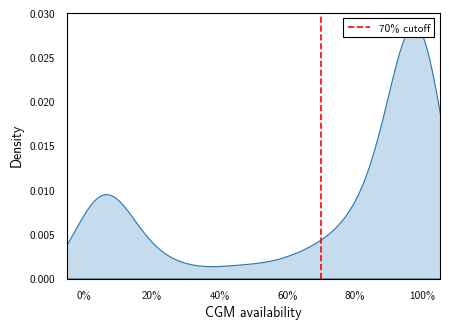

In [31]:
from matplotlib.ticker import PercentFormatter
plt.figure()
ax = sns.kdeplot(dc_agg['completeness_day']*100, fill=True)
plt.axvline(70, ls='--', color='red', label='70% cutoff')
plt.xlabel('CGM availability')
plt.xlim((-5, 105))
ax.xaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.savefig(SAVE_PATH+'completeness_cutoff_pdf.png', dpi=1000)#, bbox_inches='tight')
plt.savefig(SAVE_PATH+'completeness_cutoff_pdf.pdf')#, bbox_inches='tight')
plt.show()
plt.close()

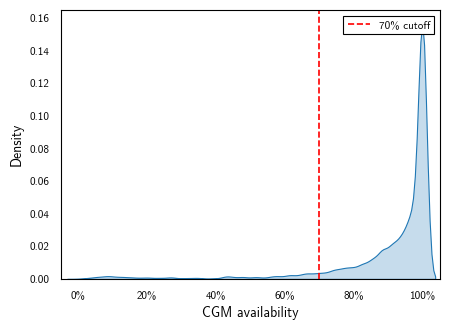

In [32]:
from matplotlib.ticker import PercentFormatter
plt.figure()
ax = sns.kdeplot(dc.dropna(subset=['Glucose Value (mg/dL)'])['completeness']*100, fill=True)
plt.axvline(70, ls='--', color='red', label='70% cutoff')
plt.xlabel('CGM availability')
plt.xlim((-5, 105))
ax.xaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.savefig(SAVE_PATH+'completeness_cutoff_values_pdf.png', dpi=1000)#, bbox_inches='tight')
plt.savefig(SAVE_PATH+'completeness_cutoff_values_pdf.pdf')#, bbox_inches='tight')
plt.show()
plt.close()

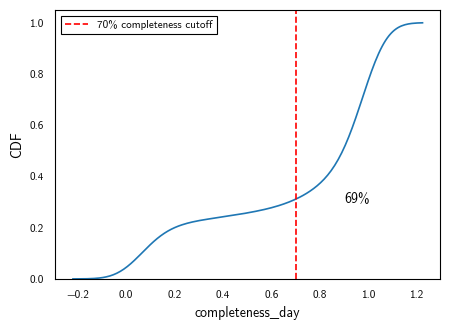

In [33]:
plt.figure()
sns.kdeplot(data=dc_agg, x='completeness_day', cumulative=True)
plt.axvline(0.7, ls='--', color='red', label='70% completeness cutoff')
plt.text(0.9,0.3, '{:.0f}%'.format((dc_agg['completeness_day'] >= 0.7).sum()/dc_agg['completeness_day'].count()*100))
plt.legend()
plt.ylabel('CDF')
plt.savefig(SAVE_PATH+'completeness_cutoff_cdf.png', dpi=1000)#, bbox_inches='tight')
plt.show()

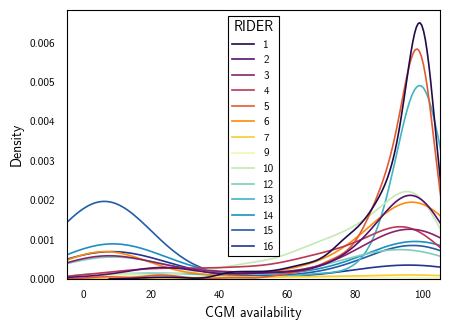

In [34]:
plt.figure()
sns.kdeplot(data=dc_agg, x=dc_agg['completeness_day']*100, hue='RIDER', palette= sns.color_palette('inferno', n_colors=7)+ sns.color_palette('YlGnBu', n_colors=7))
plt.xlabel('CGM availability')
plt.xlim((-5, 105))
ax.xaxis.set_major_formatter(PercentFormatter())
plt.show()

Calendar with glucose availability

In [35]:
dc_avail = pd.merge(dc_agg, season_list, how='right', on=['RIDER', 'date'])\
    .pivot(index='RIDER', columns='date', values='completeness_day')

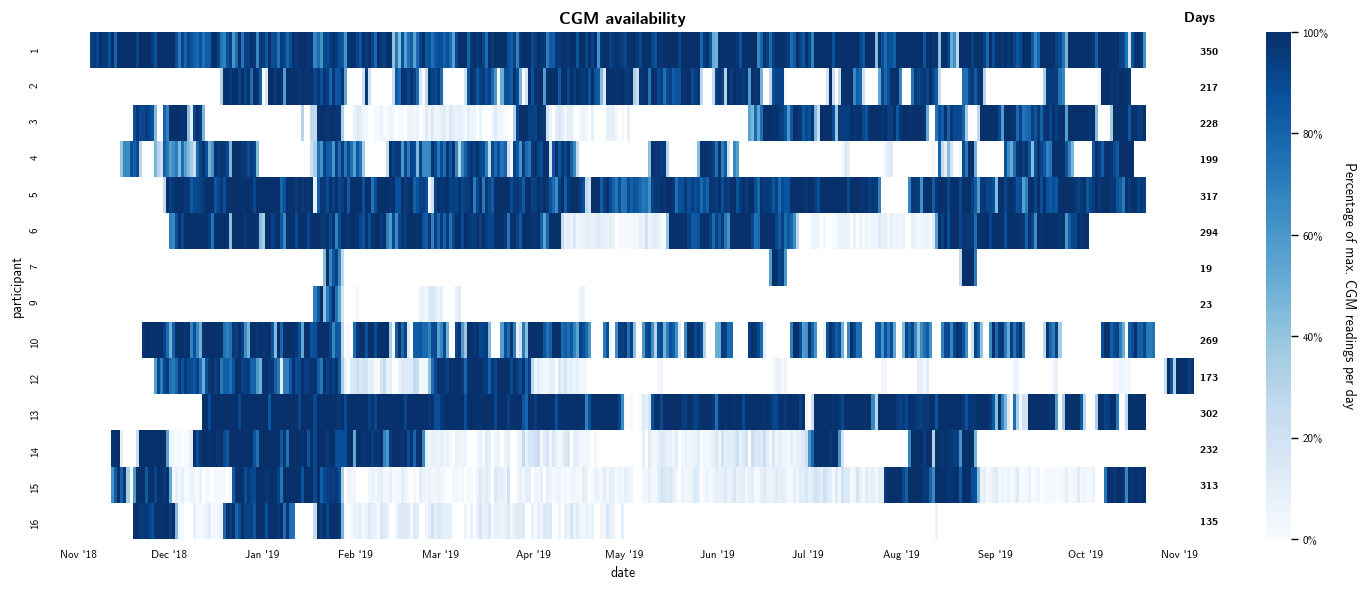

In [36]:
ax = plot_availability(dc_avail, plot_total='count')
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability', yticks=ax)

Select data with glucose completeness >= 70% (on a day from 6am to 6am) and remove nans from dexcom data

In [37]:
dc.loc[dc['completeness'] < 0.7, 'Glucose Value (mg/dL)'] = np.nan
dc = dc.dropna(subset=['Glucose Value (mg/dL)'])

In [38]:
dc_agg = dc_agg[dc_agg['completeness_day'] >= 0.7]

In [39]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 3828
Dexcom (agg): N = 14 ; D = 2133
Dexcom: N = 14 ; D = 2133


#### Select participants with 14 or more days of data

In [40]:
mask = dc_agg.groupby('RIDER')['date'].nunique() >= 14
ATHLETES = mask[mask].index

info = info.loc[ATHLETES]
season_list = season_list[season_list.RIDER.isin(ATHLETES)]

tp_agg = tp_agg[tp_agg.RIDER.isin(ATHLETES)]
dc_agg = dc_agg[dc_agg.RIDER.isin(ATHLETES)]
dc = dc[dc.RIDER.isin(ATHLETES)]

In [41]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 12 ; D = 3370
Dexcom (agg): N = 12 ; D = 2115
Dexcom: N = 12 ; D = 2115


In [42]:
print("Race days: ", 
      len(dc.loc[dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Race days with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day'] & dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Training days: ", 
      len(dc.loc[dc['exercise_day'] & ~dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Exercise days: ", 
      len(dc.loc[dc['exercise_day'], ['RIDER', 'date']].drop_duplicates()))

Race days:  261
Race days with CGM during exercise:  256
Training days:  1536
Exercise days:  1792


In [43]:
season_length = season_list.groupby('RIDER').count()
print("Season length: {:.1f} [{:.1f}-{:.1f}]".format(season_length.median().item(), 
                                                     season_length.quantile(0.25).item(),
                                                     season_length.quantile(0.75).item()))

Season length: 340.0 [314.5-343.5]


**Give participants a new ID (so that it is not confusing for the paper)**

In [44]:
map_id = {i: n+1 for n, i in enumerate(dc.groupby('RIDER').apply(stat_func).apply(pd.Series)['perc_in_target_'].sort_values(ascending=False).index)}
map_id

{13: 1,
 6: 2,
 5: 3,
 12: 4,
 15: 5,
 3: 6,
 2: 7,
 1: 8,
 16: 9,
 14: 10,
 4: 11,
 10: 12}

In [45]:
ATHLETES = sorted([*map(map_id.get, ATHLETES)])

info.index = info.index.map(map_id)
info = info.sort_index()

season.index = season.index.map(map_id)
season = season.sort_index()

season_list.RIDER = season_list.RIDER.map(map_id)

tp_agg.RIDER = tp_agg.RIDER.map(map_id)
dc_agg.RIDER = dc_agg.RIDER.map(map_id)
dc.RIDER = dc.RIDER.map(map_id)

rider_mapping_inv = {map_id[k]:v for k,v in rider_mapping_inv.items() if k in map_id.keys()}

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [46]:
dc_avail = pd.merge(dc_agg, season_list, how='right', on=['RIDER', 'date'])\
    .pivot(index='RIDER', columns='date', values='completeness_day')

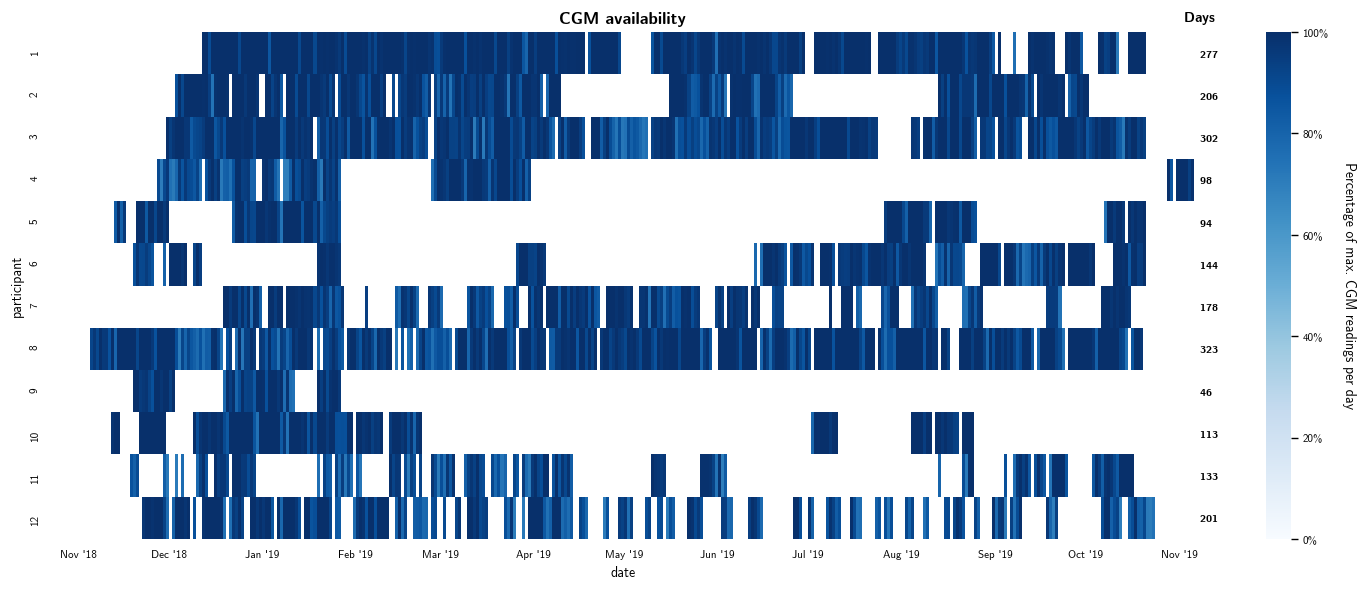

In [47]:
ax = plot_availability(dc_avail, plot_total='count')
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_selectcomp', yticks=ax)

## Descriptives Dexcom

In [48]:
def get_percinlevel(dc, col='Glucose Value (mg/dL)'):
    return {l: perc_in_level(dc[col], l, extend=False) for l, _ in glucose_levels_.items()}

### Glucose distribution (histograms)

All data

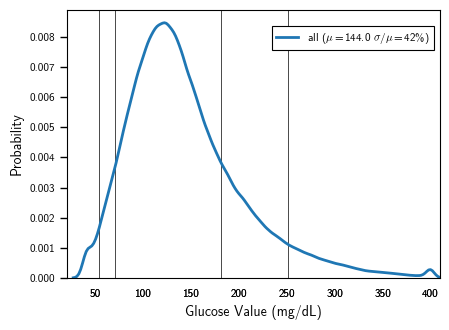

In [49]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
sns.kdeplot(dc[COL], ax=ax, linewidth=2,
	label=r'all ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
	.format(dc[COL].mean(), dc[COL].std()/dc[COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
ax.set_xlabel(COL)
savefig(path='hist/hist_glucose')

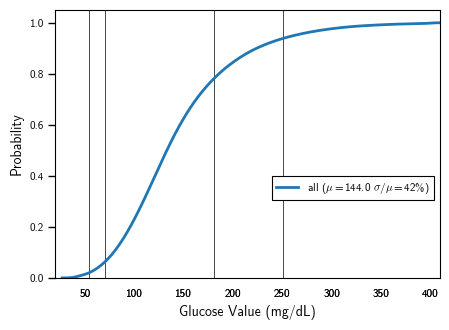

In [50]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
sns.kdeplot(dc[COL], ax=ax, cumulative=True, linewidth=2,
	label=r'all ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
	.format(dc[COL].mean(), dc[COL].std()/dc[COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.4))
ax.set_xlabel(COL)
savefig(path='cdf/cdf_glucose')

All, hue: sections

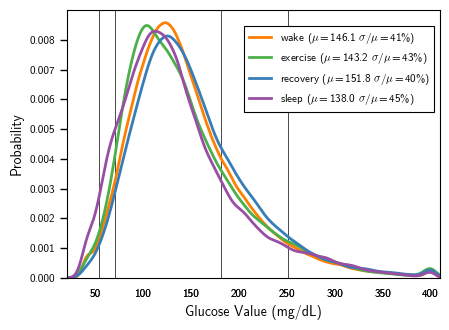

In [51]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for k, sec in enumerate(SECTIONS):
	sns.kdeplot(dc[dc[sec]][COL], ax=ax, linewidth=2, color=color_sec[sec],
		label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'.format(dc[dc[sec]][COL].mean(), dc[dc[sec]][COL].std()/dc[dc[sec]][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
savefig(path='hist/hist_glucose_sec')

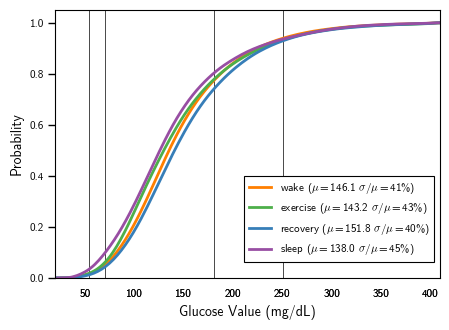

In [52]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for k, sec in enumerate(SECTIONS):
	sns.kdeplot(dc[dc[sec]][COL], ax=ax, cumulative=True, linewidth=2, color=color_sec[sec],
		label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'.format(dc[dc[sec]][COL].mean(), dc[dc[sec]][COL].std()/dc[dc[sec]][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.4))
savefig(path='cdf/cdf_glucose_sec')

Individual athletes, hue: sections

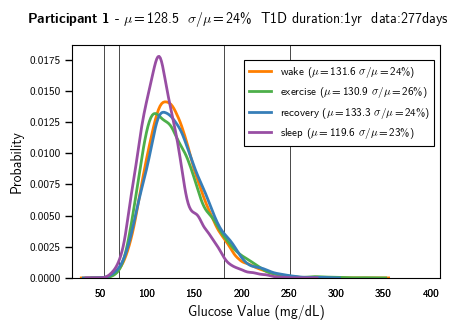

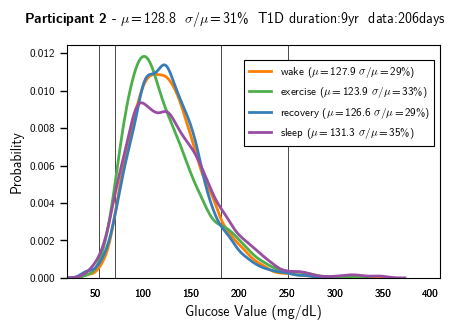

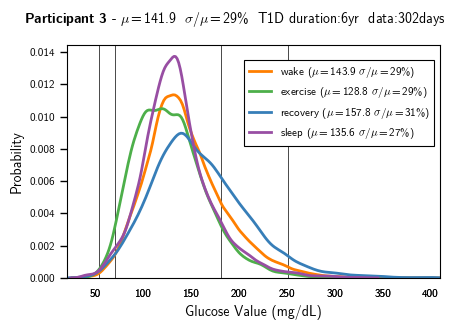

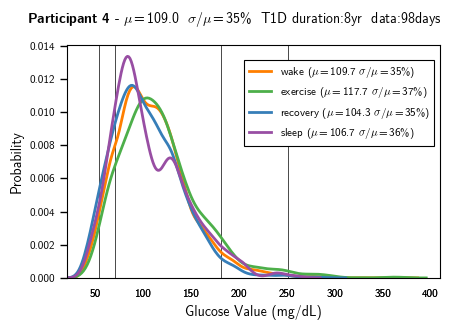

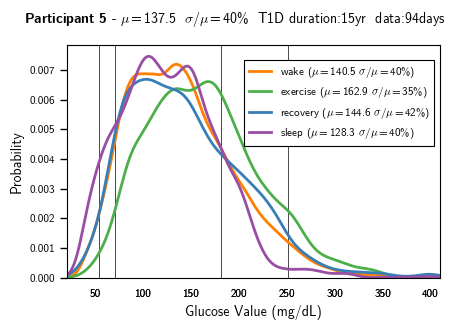

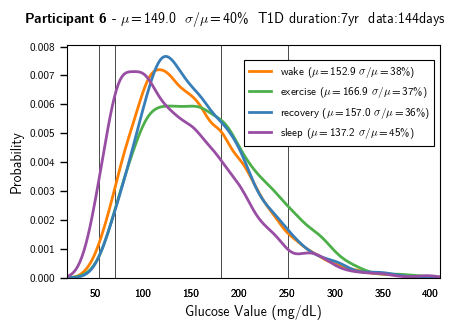

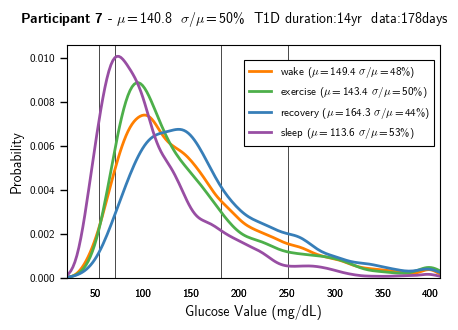

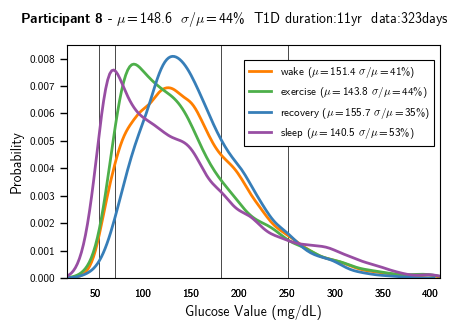

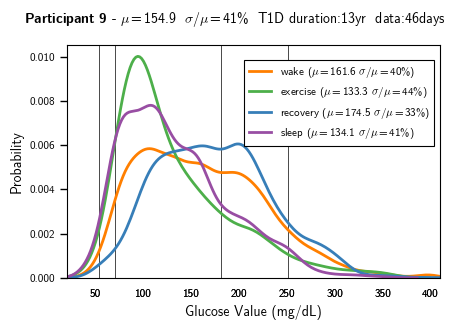

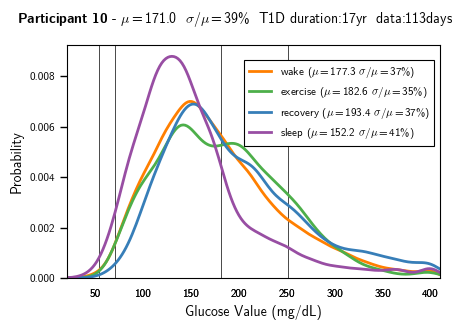

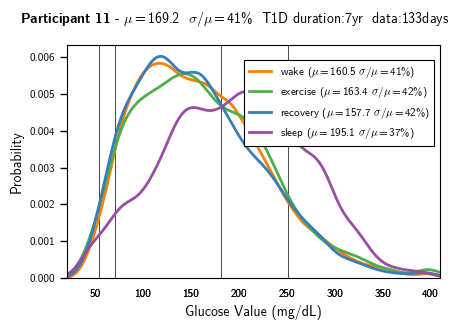

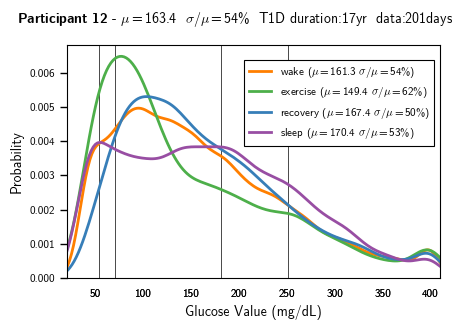

In [53]:
for i in ATHLETES:
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	
	for k, sec in enumerate(SECTIONS):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, linewidth=2, color=color_sec[sec],
			label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL)
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg[dc_agg.RIDER == i]))
	savefig(path='hist/hist_glucose_rider', i=i, title=title, x=0.45, y=1.06)

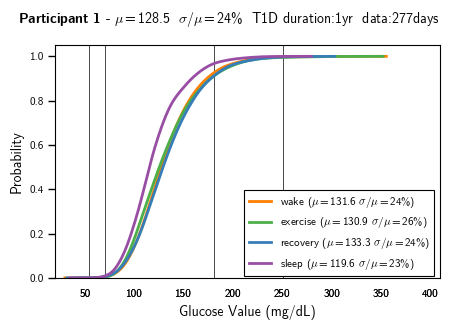

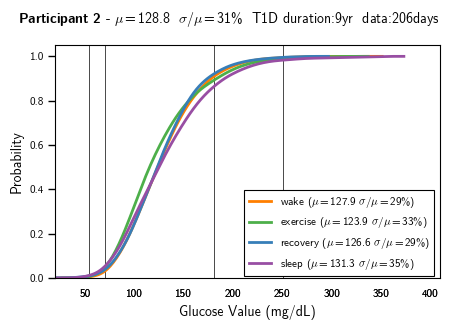

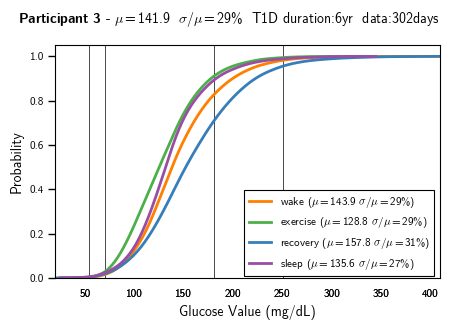

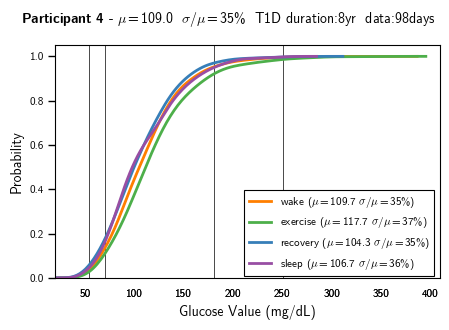

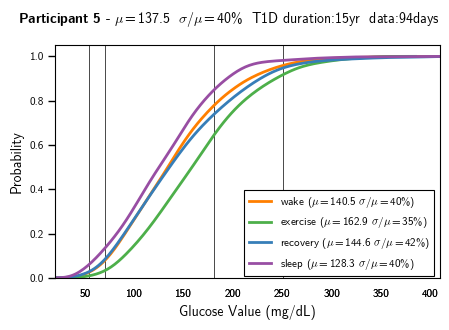

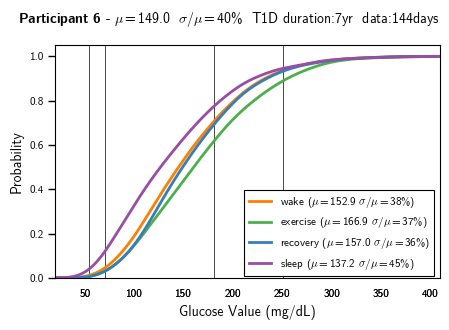

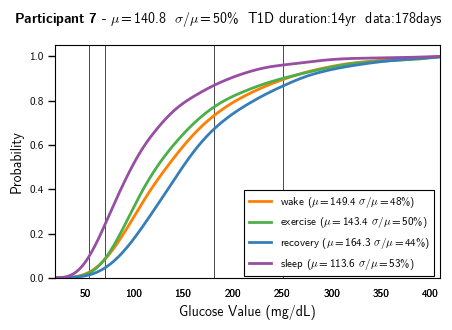

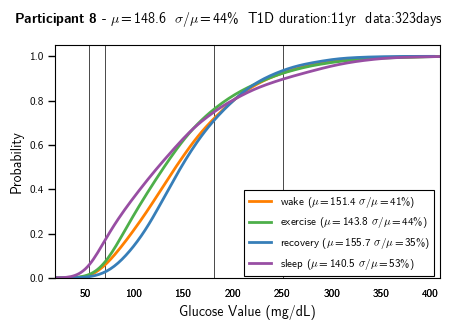

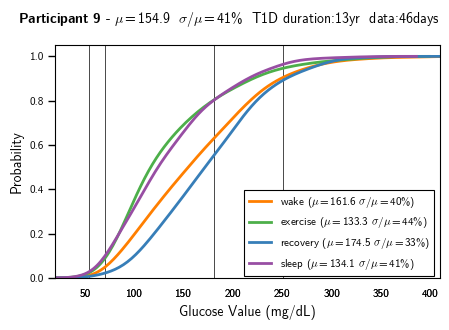

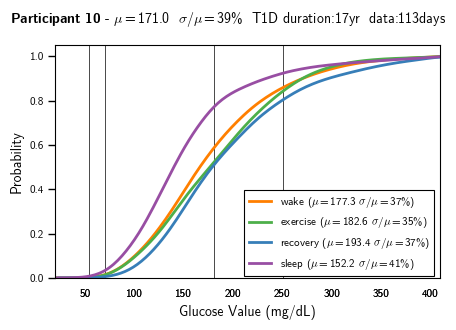

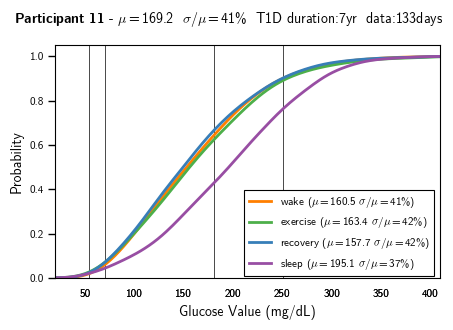

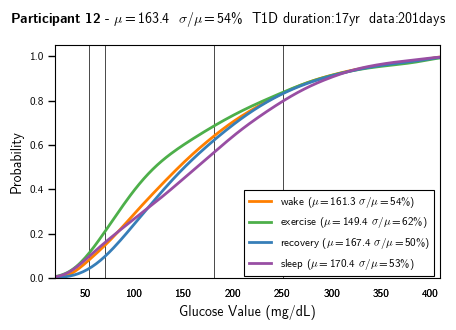

In [54]:
for i in ATHLETES:
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	
	for k, sec in enumerate(SECTIONS):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, cumulative=True, 
			linewidth=2, color=color_sec[sec],
			label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.4))
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg[dc_agg.RIDER == i]))
	savefig(path='cdf/cdf_glucose_rider', i=i, title=title, x=0.45, y=1.06)

All, hue: athletes

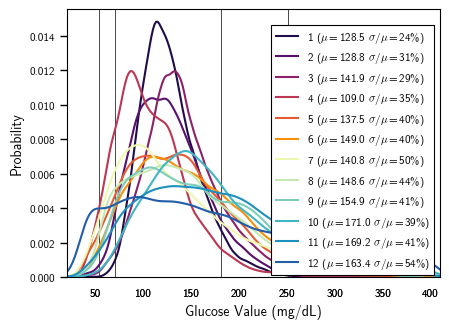

In [55]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for c, i in enumerate(ATHLETES):
	sns.kdeplot(dc[dc.RIDER == i][COL], ax=ax, 
		linewidth=1.5, color=palette_ath[c], alpha=.8,
		label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
		.format(dc[dc.RIDER == i][COL].mean(), 
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
savefig(path='hist/hist_glucose_riders', legend=ax.get_legend().get_texts())

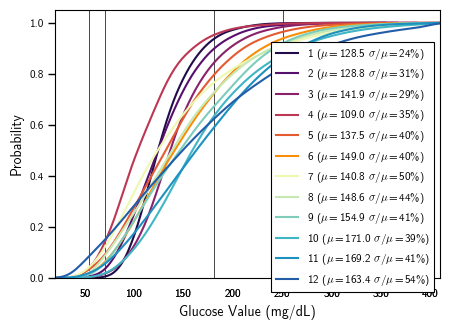

In [56]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for c, i in enumerate(ATHLETES):
	sns.kdeplot(dc[dc.RIDER == i][COL], ax=ax, cumulative=True,
		linewidth=1.5, color=palette_ath[c], alpha=.8,
		label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
		.format(dc[dc.RIDER == i][COL].mean(), 
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.9))
savefig(path='cdf/cdf_glucose_riders', legend=ax.get_legend().get_texts())

Sections individually, hue: athletes

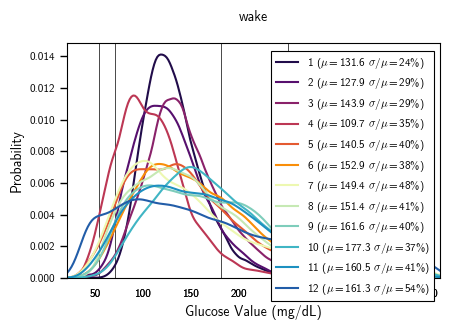

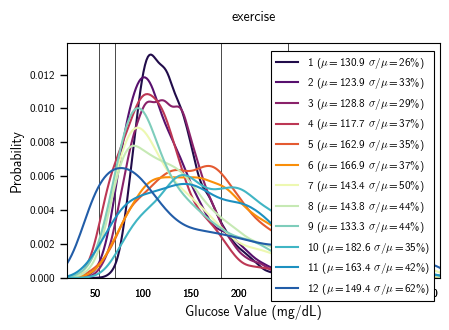

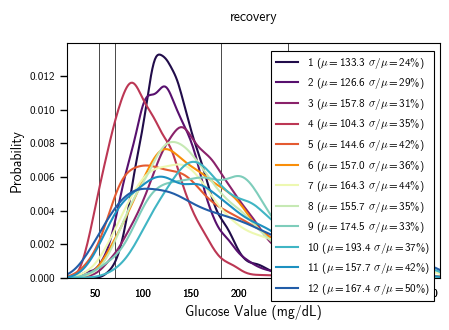

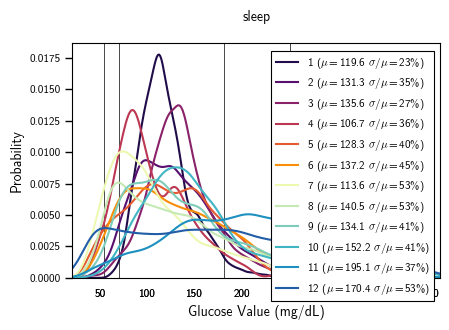

In [57]:
for k, sec in enumerate(SECTIONS):
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	for c, i in enumerate(ATHLETES):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, 
			linewidth=1.5, color=palette_ath[c], alpha=.8,
			label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.99))
	plt.title(sec, y=1.06)
	savefig(path='hist/hist_glucose_sec', i=sec, legend=ax.get_legend().get_texts())

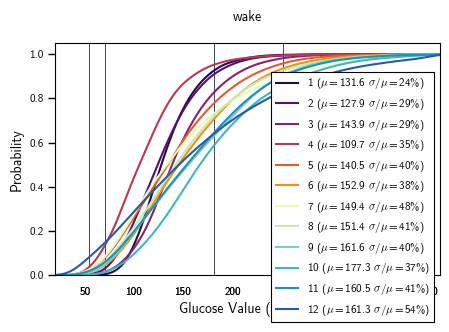

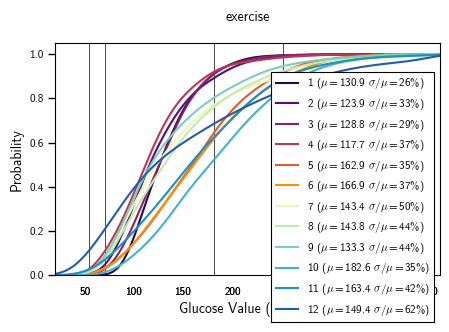

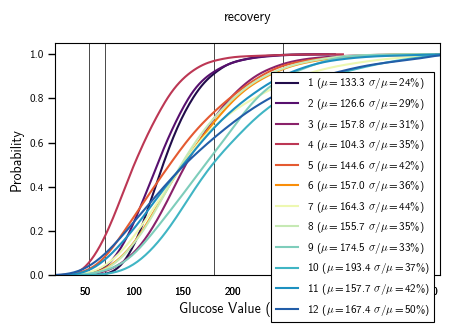

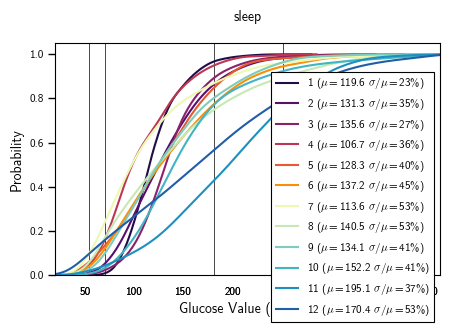

In [58]:
for k, sec in enumerate(SECTIONS):
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	for c, i in enumerate(ATHLETES):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, 
			cumulative=True, linewidth=1.5, color=palette_ath[c], alpha=.8,
			label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.9))
	plt.title(sec, y=1.06)
	savefig(path='cdf/cdf_glucose_sec', i=sec, legend=ax.get_legend().get_texts())

**CONCLUSION** : Large differences among athletes

### Glucose time in level (barcharts)

In [59]:
legend_elements = [Patch(facecolor=c, edgecolor='white', hatch=h, label=l) \
    for c, l, h in zip([(0, 0, 0), (.5, .5, .5), (.9, .9, .9), (.5, .5, .5), (0, 0, 0)],#sns.diverging_palette(10, 10, s=0, n=5), 
                       ['>250 mg/dL', '>180-250 mg/dL', '70-180 mg/dL', '<70-54 mg/dL', '<54 mg/dL'], 
                       ('//', '//', None, '\\\\', '\\\\'))] 

colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
			for c in [rgb_to_hls(*j) for j in color_sec.values()]]

All, hue: stages

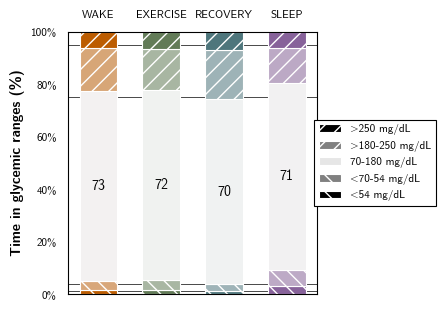

In [60]:
fig, ax = plt.subplots(figsize=(4.6, 3.2))

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

for k, sec in enumerate(SECTIONS):
    pil = get_percinlevel(dc[dc[sec]])
    #pil = {l: dc_agg.groupby('RIDER').mean()[f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
    plot_bar(pil, x=k, width=.6, colors=colors[k], plot_numbers='half')

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')

ax.set_xticklabels([sec.upper() for sec in SECTIONS])

ax.xaxis.set_label_position('top')
#ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
sns.despine(ax=ax, bottom=False, right=False, top=False)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
savefig('time_in_zone/time_in_glucoselevel')

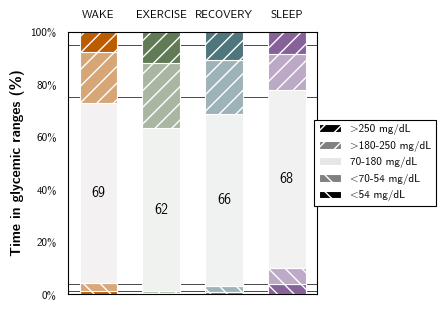

In [61]:
fig, ax = plt.subplots(figsize=(4.6, 3.2))

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

for k, sec in enumerate(SECTIONS):
    pil = get_percinlevel(dc[dc[sec] & dc['race_day'] & dc['exercise_day']])
    #pil = {l: dc_agg[dc_agg['race_day'] & dc_agg['exercise_day']].groupby('RIDER').mean()[f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
    plot_bar(pil, x=k, width=.6, colors=colors[k], plot_numbers='half')

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')

ax.set_xticklabels([sec.upper() for sec in SECTIONS])

ax.xaxis.set_label_position('top')
#ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
sns.despine(ax=ax, bottom=False, right=False, top=False)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
savefig('time_in_zone/time_in_glucoselevel_competition')

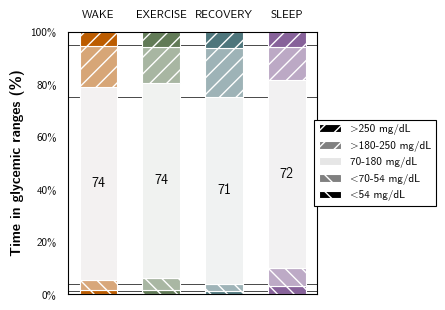

In [62]:
fig, ax = plt.subplots(figsize=(4.6, 3.2))

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

for k, sec in enumerate(SECTIONS):
    pil = get_percinlevel(dc[dc[sec] & ~dc['race_day'] & dc['exercise_day']])
    #pil = {l: dc_agg[~dc_agg['race_day'] & dc_agg['exercise_day']].groupby('RIDER').mean()[f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
    plot_bar(pil, x=k, width=.6, colors=colors[k], plot_numbers='half')

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')

ax.set_xticklabels([sec.upper() for sec in SECTIONS])

ax.xaxis.set_label_position('top')
#ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
sns.despine(ax=ax, bottom=False, right=False, top=False)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
savefig('time_in_zone/time_in_glucoselevel_training')

Individual athletes, hue: stages

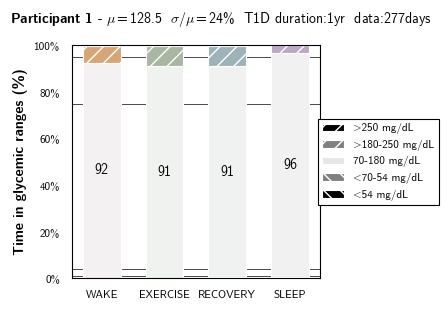

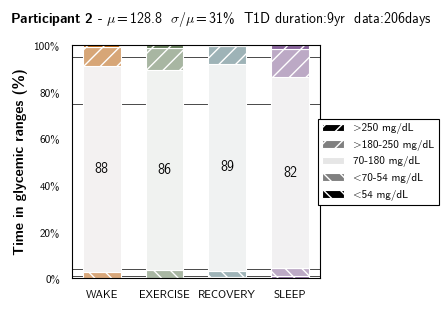

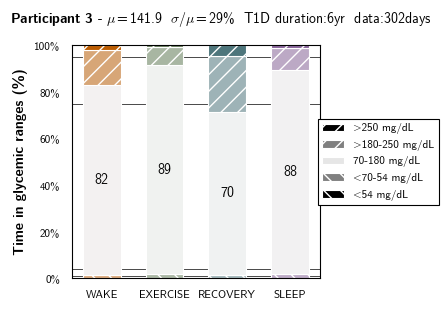

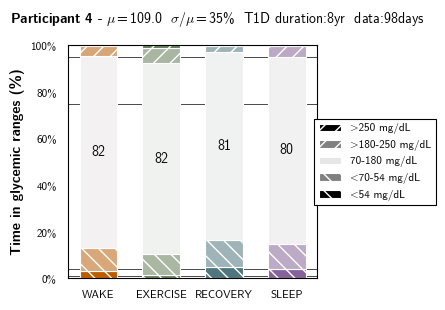

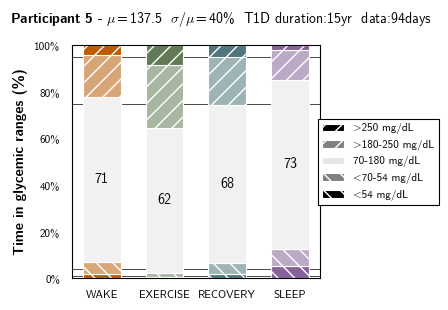

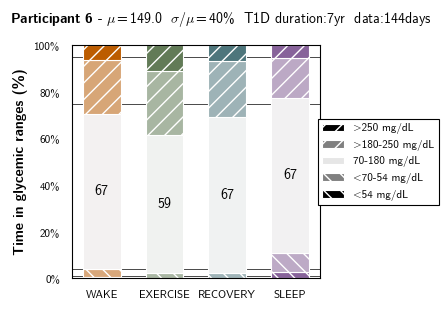

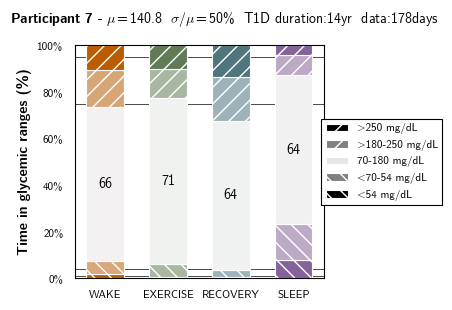

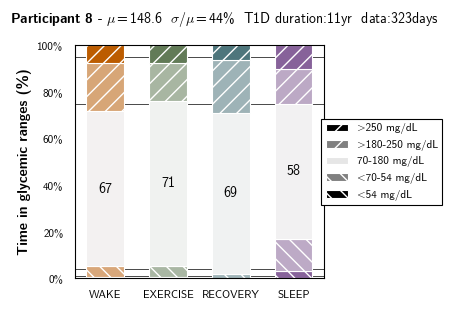

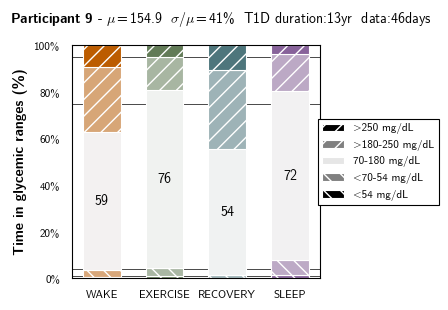

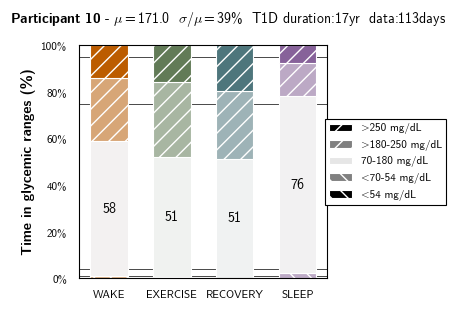

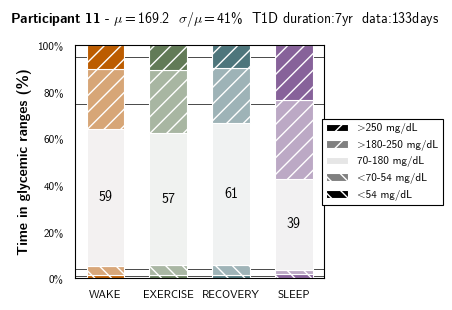

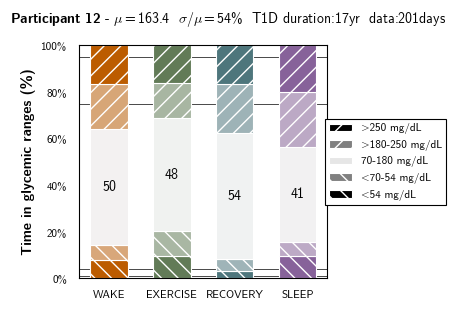

In [63]:
# TODO: check if calculation of perc_in_level is now correct!! (irvine looks weird!)
for i in ATHLETES:
    fig, ax = plt.subplots(figsize=(4.6, 3.2))

    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    for k, sec in enumerate(SECTIONS):
        pil = get_percinlevel(dc[dc[sec] & (dc.RIDER == i)])
        #pil = {l: dc_agg[dc_agg.RIDER == i][f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, x=k, colors=colors[k], width=.6, plot_numbers='half')

    plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
    plt.ylim((0,100))
    plt.ylabel('Time in glycemic ranges (%)', weight='bold')

    ax.set_xticklabels([sec.upper() for sec in SECTIONS])

    ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
    sns.despine(ax=ax, bottom=False, right=False, top=False)
    ax.tick_params(axis='both', which='major', labelbottom=True, bottom=False, top=False, labeltop=False)

    title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
        .format(dc[dc.RIDER == i][COL].mean(),
                dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
                info.loc[i, 'diabetes_duration'],
                len(dc_agg[dc_agg.RIDER == i]))
    savefig(path='time_in_zone/time_in_glucoselevel', i=i, title=title, x=0.6, y=1.06)

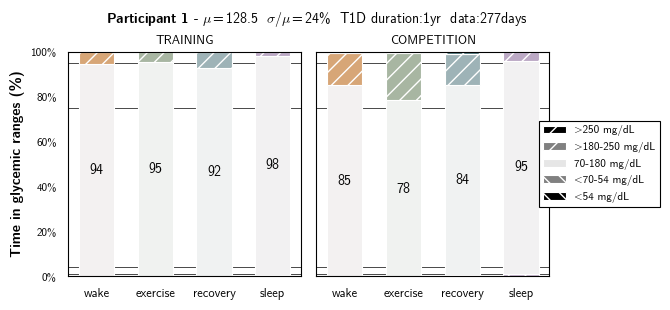

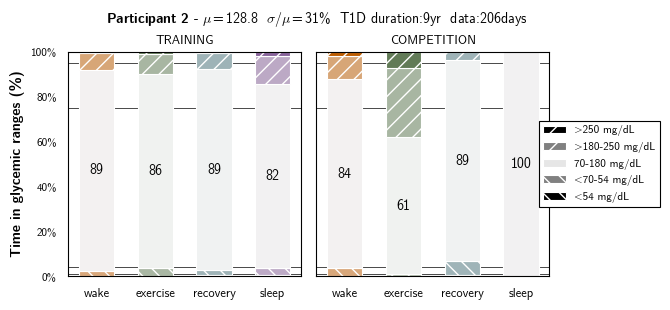

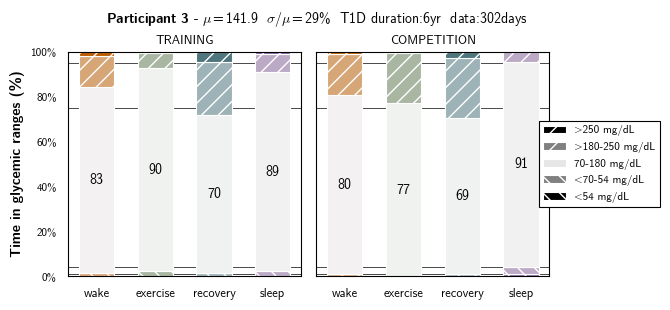

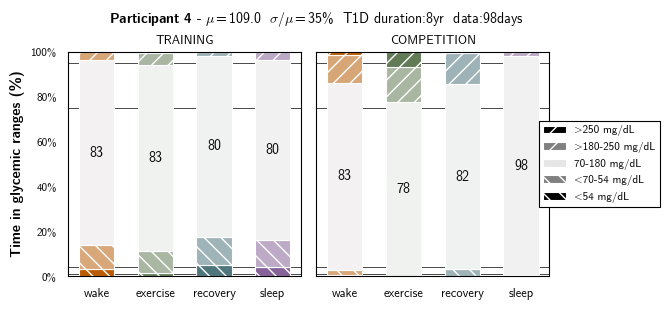

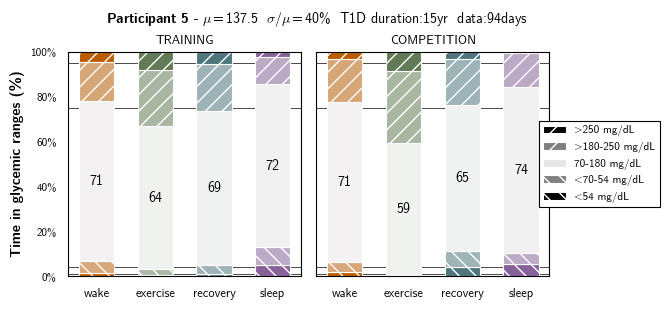

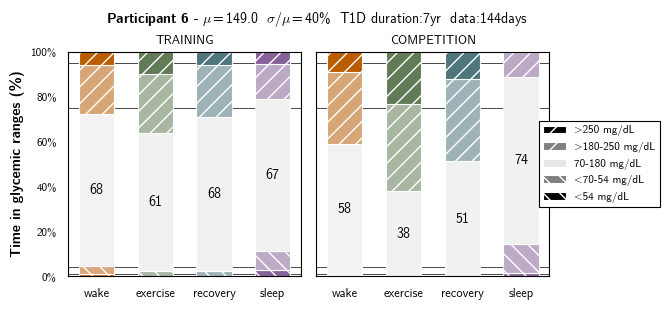

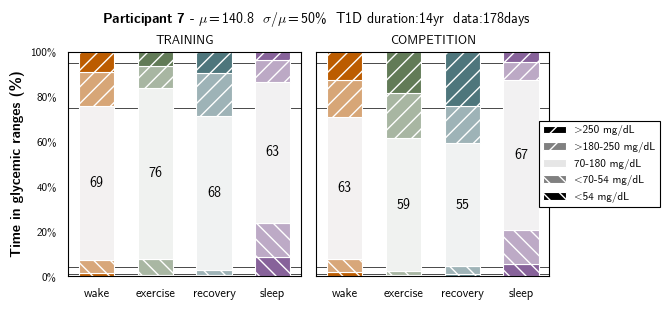

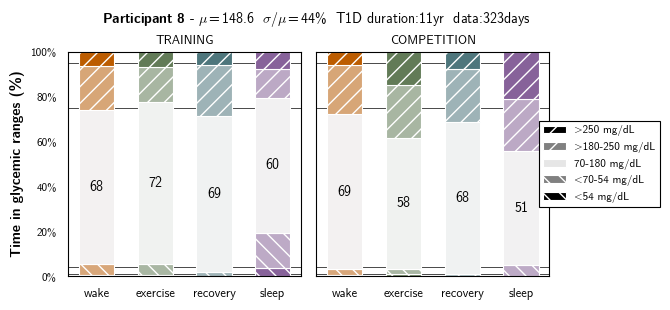

/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/eva

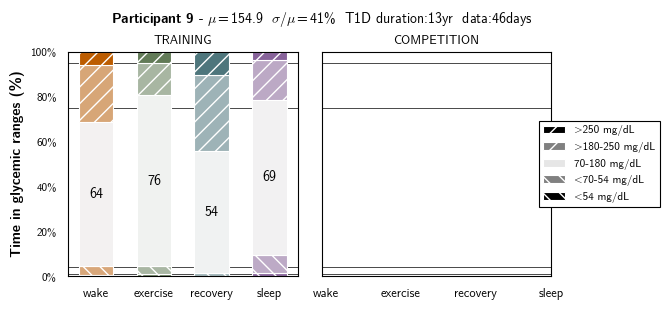

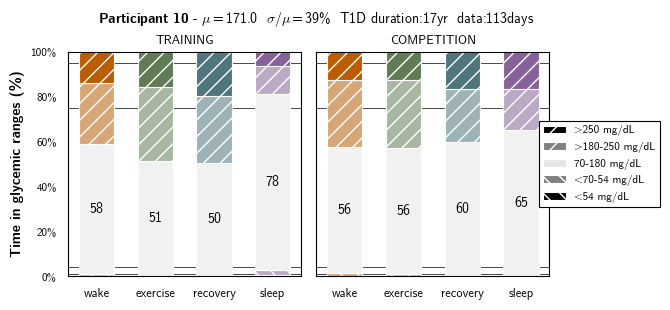

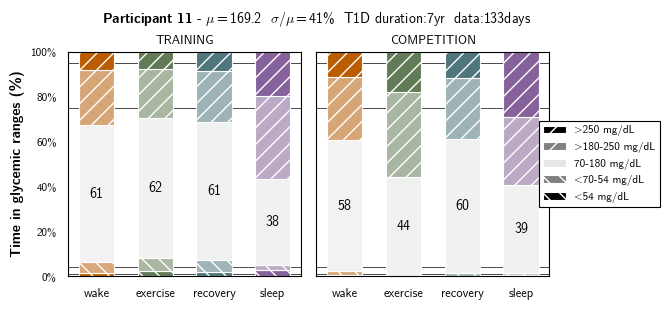

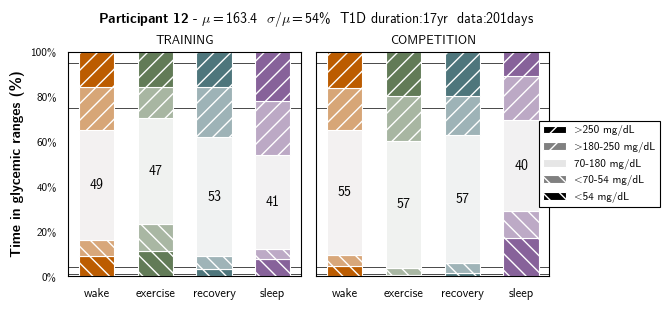

In [64]:
for i in ATHLETES:
    fig, axs = plt.subplots(1,2, figsize=(6.8, 3.2), sharey=True)
    
    for ax in axs:
        # grid in plot
        ax.axhline(1, color='k', linewidth=.5, zorder=1)
        ax.axhline(4, color='k', linewidth=.5, zorder=1)
        ax.axhline(75, color='k', linewidth=.5, zorder=1)
        ax.axhline(95, color='k', linewidth=.5, zorder=1)

    for k, sec in enumerate(SECTIONS):
        pil = get_percinlevel(dc[dc[sec] & (dc.RIDER == i) & dc['exercise_day'] & ~dc['race_day']])
        #pil = {l: dc_agg[(dc_agg.RIDER == i) & dc_agg['exercise_day'] & ~dc_agg['race_day']][f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, x=k, colors=colors[k], width=.6, plot_numbers='half', ax=axs[0])
    
    for k, sec in enumerate(SECTIONS):
        pil = get_percinlevel(dc[dc[sec] & (dc.RIDER == i) & dc['exercise_day'] & dc['race_day']])
        #pil = {l: dc_agg[(dc_agg.RIDER == i) & dc_agg['exercise_day'] & dc_agg['race_day']][f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, x=k, colors=colors[k], width=.6, plot_numbers='half', ax=axs[1])

    axs[0].text(0.5, 1.02, 'Training'.upper(), ha='center', va='bottom', transform=axs[0].transAxes, fontsize=9)
    axs[1].text(0.5, 1.02, 'Competition'.upper(), ha='center', va='bottom', transform=axs[1].transAxes, fontsize=9)
    
    for ax in axs:
        ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
        ax.set_xticks(np.arange(len(SECTIONS)), SECTIONS)
        ax.set_ylim((0,100))
        
        ax.set_xticklabels(SECTIONS, fontsize=9)        
        sns.despine(ax=ax, bottom=False, right=False, top=False)
        ax.tick_params(axis='both', which='major', labelbottom=True, bottom=False, top=False, labeltop=False)

    axs[0].set_ylabel('Time in glycemic ranges (%)', weight='bold')
  
    axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))

    title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
        .format(dc[dc.RIDER == i][COL].mean(),
                dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
                info.loc[i, 'diabetes_duration'],
                len(dc_agg[dc_agg.RIDER == i]))
    savefig(path='time_in_zone/time_in_glucoselevel_traincomp', i=i, title=title, x=0, y=1.09)

All, hue: athletes

In [65]:
colorful=False

In [66]:
if colorful:
    colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
                        for c in [rgb_to_hls(*j) for j in palette_ath]]
    kws = dict(ref_color = dict(h_neg=10, h_pos=10, s=0, l=50),
               ref_color_rgb = 'black',
               dur_color = 'black',
               dur_cmap = 'Greys')
else:
    colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
                        for c in [rgb_to_hls(*j) for j in len(palette_ath)*[(0, 0, 0)]]]
    kws = dict(ref_color = dict(h_pos=360, h_neg=360, l=50, s=80),
               ref_color_rgb = sns.diverging_palette(h_pos=360, h_neg=360, l=50, s=80, n=5)[0],
               dur_color = sns.diverging_palette(h_pos=90, h_neg=90, l=50, s=80, n=5)[0],
               dur_cmap = sns.light_palette((90/360, 50/360, 80/100), input='hls', as_cmap=True))

In [67]:
def plot_bar_reference(ax, n, colors=dict(h_neg=10, h_pos=10, s=0, l=50), text=True):
    ax.plot((n+1-0.2, n+1-0.2), (0, 110), color='black', clip_on=False)
    plot_bar({'hypo L2':1.2, 'hypo L1':3.2, 'target':70.2, 'hyper L1':20.2, 'hyper L2':5.2}, 
             x=n+1.5, width=.7, plot_numbers='full', ax=ax, labelsize=8, colors=colors)
    ax.annotate('3', xy=(n+1.5, 2.5), xytext=(n+2, 5), ha='left', arrowprops=dict(arrowstyle="-", color='black'), fontsize=8)
    ax.annotate('1', xy=(n+1.5, 0.5), xytext=(n+2, 0.5), ha='left', arrowprops=dict(arrowstyle="-", color='black'), fontsize=8)
    if text:
        ax.text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=sns.diverging_palette(**colors, n=5)[0])

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.png', dpi=1000)#, bbox_inches='tigh

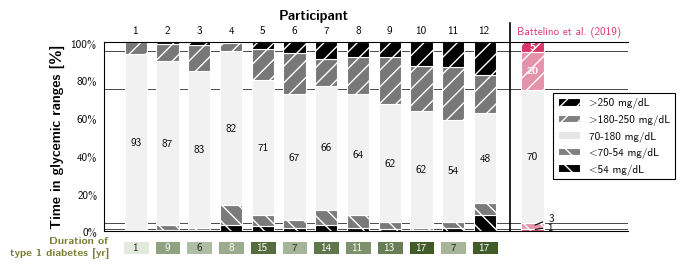

In [68]:
fig, (ax, ax0) = plt.subplots(2,1, figsize=(6.8,2.5), gridspec_kw={'height_ratios':[10,1], 'hspace': 0.07})

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

# plot bars
for n, i in enumerate(ATHLETES):
    pil = get_percinlevel(dc[dc.RIDER == i])
    #pil = {l: dc_agg[dc_agg.RIDER == i][f"perc_in_{l.replace(' ', '')}_day"].mean() for l in glucose_levels_.keys()}
    plot_bar(pil, x=n, width=.7, colors=colors[n], #duration=info['diabetes_duration'][i], 
             ax=ax, plot_numbers='half', labelsize=8)

# plot reference
plot_bar_reference(ax, n, colors=kws['ref_color'])
    
# ticks and axes
ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
ax.set_xticks(np.arange(len(ATHLETES)), ATHLETES)
ax.set_xlim((-1, 15.5))
ax.set_ylim((0,100))
ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')
ax.set_xlabel('Participant', weight='bold')
ax.xaxis.set_label_position('top')
ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)

if colorful:
    for n, i in enumerate(ATHLETES):
        ax.get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=ax, bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=ax0, xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
ax0.set_xlim((-0.5, 16))
ax0.set_xlabel(None)
ax0.text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
ax0.text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

plt.subplots_adjust(left=0.15, right=0.92, top=0.87, bottom=0.01)

savefig('time_in_zone/time_in_glucoselevel_riders', xticks=ax)

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.png', dpi=1000)#, bbox_inches='tigh

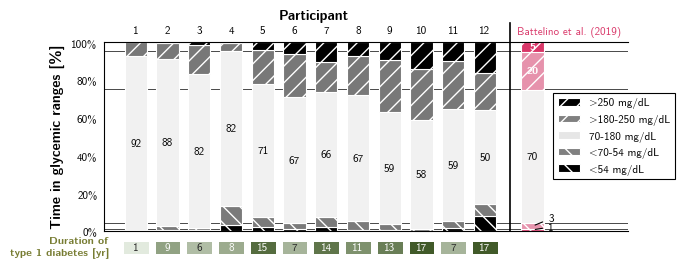

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.png', dpi=1000)#, bbox_inches='tigh

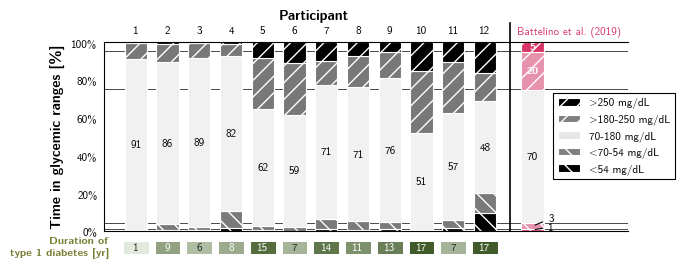

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.png', dpi=1000)#, bbox_inches='tigh

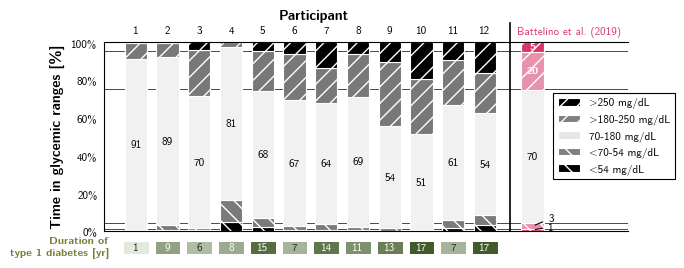

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.png', dpi=1000)#, bbox_inches='tigh

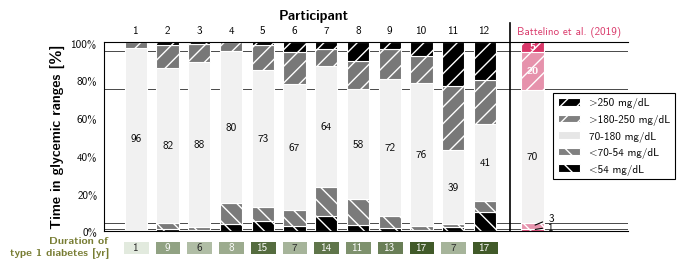

In [69]:
for sec in SECTIONS:
    fig, (ax, ax0) = plt.subplots(2,1, figsize=(6.8,2.5), gridspec_kw={'height_ratios':[10,1], 'hspace': 0.07})

    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    # plot bars
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        #pil = {l: dc_agg[dc_agg.RIDER == i][f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, x=n, width=.7, colors=colors[n], #duration=info['diabetes_duration'][i], 
                 ax=ax, plot_numbers='half', labelsize=8)

    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'])
    
    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xticks(np.arange(len(ATHLETES)), ATHLETES)
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')
    ax.set_xlabel('Participant', weight='bold')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_label_coords(0.4, 1.12)
    ax.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)

    for n, i in enumerate(ATHLETES):
        ax.get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

    ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
    sns.despine(ax=ax, bottom=False, right=True, top=False)

    # diabetes duration on bottom
    sns.heatmap(info['diabetes_duration'].to_frame().T, ax=ax0, xticklabels=False, yticklabels=False,
                annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
    ax0.set_xlim((-0.5, 16))
    ax0.set_xlabel(None)
    ax0.text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
    ax0.text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

    #ax0.text(n/2, 2, sec.upper())
    plt.subplots_adjust(left=0.15, right=0.92, top=0.87, bottom=0.01)

    savefig('time_in_zone/time_in_glucoselevel_riders_%s'%sec, xticks=ax)

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.png', dpi=1000)#, bbox_inches='tigh

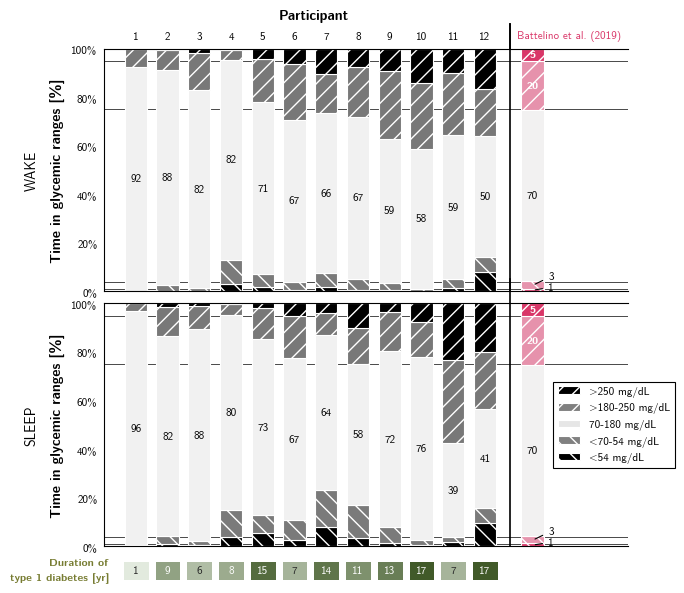

In [70]:
fig, axs = plt.subplots(3,1, figsize=(6.8,6), gridspec_kw={'height_ratios':[10, 10,1], 'hspace': 0.07})

for ax, sec in zip(axs[:2], ('wake', 'sleep')):
    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    # plot bars
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        #pil = {l: dc_agg[dc_agg.RIDER == i][f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, x=n, width=.7, colors=colors[n], ax=ax, plot_numbers='half', labelsize=8)

    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'], text=False)

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')

    ax.text(-3.5, 50, sec.upper(), rotation=90, va='center')

axs[0].plot((n+1-0.2, n+1-0.2), (100, 110), color='black', clip_on=False)

# reference
axs[0].text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=kws['ref_color_rgb'])

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES)
axs[0].set_xlabel('Participant', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_label_coords(0.4, 1.12)
axs[0].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)
axs[1].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=False, pad=0)

for n, i in enumerate(ATHLETES):
    axs[0].get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=axs[0], bottom=False, right=True, top=False)
sns.despine(ax=axs[1], bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=axs[2], xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
axs[2].set_xlim((-0.5, 16))
axs[2].set_xlabel(None)
axs[2].text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
axs[2].text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

plt.subplots_adjust(left=0.15, right=0.92, top=0.92, bottom=0.03)

savefig('time_in_zone/time_in_glucoselevel_riders_daynight', xticks=axs[0])

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.png', dpi=1000)#, bbox_inches='tigh

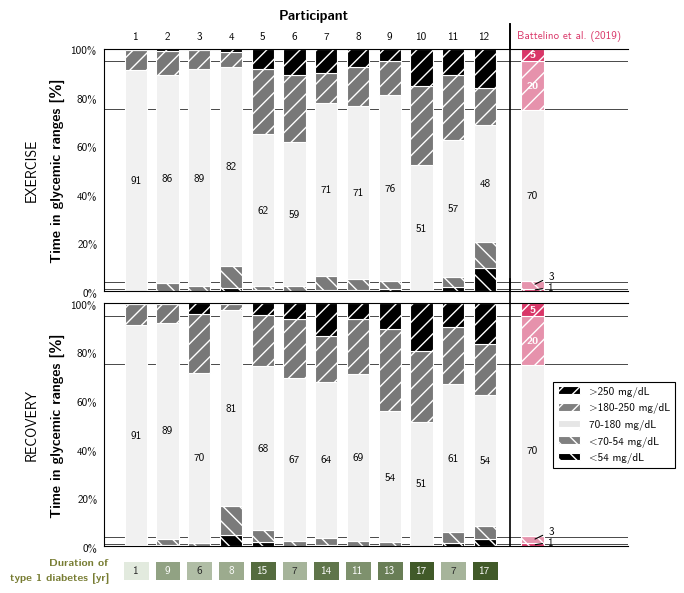

In [71]:
fig, axs = plt.subplots(3,1, figsize=(6.8,6), gridspec_kw={'height_ratios':[10, 10,1], 'hspace': 0.07})

for ax, sec in zip(axs[:2], ('exercise', 'recovery')):
    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    # plot bars
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        #pil = {l: dc_agg[dc_agg.RIDER == i][f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, x=n, width=.7, colors=colors[n], ax=ax, plot_numbers='half', labelsize=8)

    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'], text=False)

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')

    ax.text(-3.5, 50, sec.upper(), rotation=90, va='center')

axs[0].plot((n+1-0.2, n+1-0.2), (100, 110), color='black', clip_on=False)

# reference
axs[0].text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=kws['ref_color_rgb'])

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES)
axs[0].set_xlabel('Participant', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_label_coords(0.4, 1.12)
axs[0].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)
axs[1].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=False, pad=0)

for n, i in enumerate(ATHLETES):
    axs[0].get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=axs[0], bottom=False, right=True, top=False)
sns.despine(ax=axs[1], bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=axs[2], xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
axs[2].set_xlim((-0.5, 16))
axs[2].set_xlabel(None)
axs[2].text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
axs[2].text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

plt.subplots_adjust(left=0.15, right=0.92, top=0.92, bottom=0.03)

savefig('time_in_zone/time_in_glucoselevel_riders_exerciserecovery', xticks=axs[0])

/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/eva

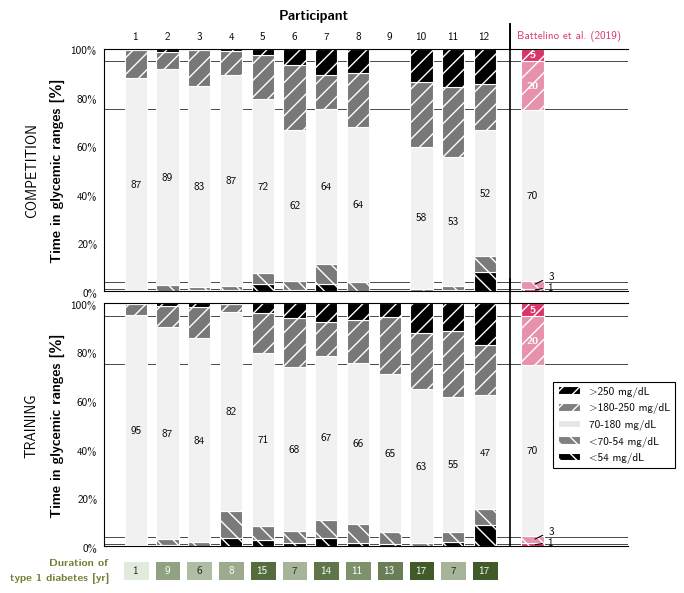

In [72]:
fig, axs = plt.subplots(3,1, figsize=(6.8,6), gridspec_kw={'height_ratios':[10, 10,1], 'hspace': 0.07})
MASK = {'competition': dc['race_day'] & dc['exercise_day'],
        'training'   : ~dc['race_day'] & dc['exercise_day']}
for ax, (sec, mask) in zip(axs[:2], MASK.items()):
    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & mask])
        #pil = {l: dc_agg[(dc_agg.RIDER == i) & mask][f"perc_in_{l.replace(' ', '')}_exercise"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, ax=ax, x=n, width=.7, colors=colors[n], plot_numbers='half', labelsize=8)
    
    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'], text=False)

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')
        
    ax.text(-3.5, 50, sec.upper(), rotation=90, va='center')

axs[0].plot((n+1-0.2, n+1-0.2), (100, 110), color='black', clip_on=False)
 
# reference
axs[0].text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=kws['ref_color_rgb'])

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES)
axs[0].set_xlabel('Participant', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_label_coords(0.4, 1.12)
axs[0].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)
axs[1].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=False, pad=0)

for n, i in enumerate(ATHLETES):
    axs[0].get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=axs[0], bottom=False, right=True, top=False)
sns.despine(ax=axs[1], bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=axs[2], xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
axs[2].set_xlim((-0.5, 16))
axs[2].set_xlabel(None)
axs[2].text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
axs[2].text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

plt.subplots_adjust(left=0.15, right=0.92, top=0.92, bottom=0.03)

savefig('time_in_zone/time_in_glucoselevel_riders_competitiontrain', xticks=axs[0])

**CONCLUSION** : Large differences among athletes

## Summary Statistics

### Participant characteristics

In [73]:
info['bmi'] = info['weight'] / (info['height']/100)**2

In [74]:
# ------ info
cols_info = {'age'    : 'Age [yr]',
             'gender' : 'Sex [male/female]',
             'height' : 'Height [cm]',
             'weight' : 'Weight [kg]',
             'bf(%)'  : 'Fat mass [\%]'}

info['FTP_per_kg'] = info['FTP'] / info['weight']
info = info.drop('FTP', axis=1)

stats_info = info.loc[:,info.columns.isin(cols_info.keys())]
stats_info = stats_info.rename(columns=cols_info)

In [75]:
# ------ diabetes
cols_diab = {'diabetes_duration' : 'Diabetes duration [yr]',
             'HbA1c'             : 'HbA_{1c} [\%]',
             'cgm_days'          : 'Days with CGM coverage $\geq$ 70 \%'}

stats_diab = info.loc[:, info.columns.isin(cols_diab.keys())]
stats_diab['cgm_days'] = dc_agg.reset_index().groupby('RIDER')['date'].count()
stats_diab = stats_diab.rename(columns=cols_diab)

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [76]:
# ------ exercise
cols_ex = {'FTP_per_kg'                : 'Functional threshold power (FTP) [W/kg]',
           'LTHR'                      : 'Lactate threshold heart rate (LTHR) [bpm]',
           'HRmax'                     : 'Maximum heart rate (HR_{max}) [bpm]',
           'VO2max'                    : 'Maximum rate of oxygen consumption (VO_{2max}) [mL/min/kg]',
           'days_per_year_cycled'      : 'Cycling [days/yr]',
           'days_per_year_raced'       : 'Competition [days/yr]',
           'km_per_year_cycled'        : 'Distance cycled [km/yr]',
           'mean_hours_per_day_cycled' : 'Mean time cycled [h/day]',
           'mean_km_per_day_cycled'    : 'Mean distance cycled [km/day]',
           'mean_m_per_day_ascended'   : 'Mean ascension [m/day]'}

tp_agg0 = tp_agg.set_index(['RIDER', 'date'])
tp_agg0.columns = tp_agg0.columns.get_level_values(1)
tp_agg0 = tp_agg0.reset_index()

stats_ex_yr = tp_agg0.groupby('RIDER').agg({'date'        :'count', 
                                            'race'        :'sum', 
                                            'distance_max':lambda x: x.sum()/1000})\
                           .rename(columns={'date'        :'days_per_year_cycled',
                                            'race'        :'days_per_year_raced',
                                            'distance_max':'km_per_year_cycled'})

stats_ex_day = tp_agg0.groupby('RIDER').agg({'timestamp_count'      :lambda x: x.mean()/3600,
                                             'distance_max'         :lambda x: x.mean()/1000,
                                             'elevation_gain_up_sum':'mean'})\
    .rename(columns={'timestamp_count'      :'mean_hours_per_day_cycled',
                     'distance_max'         :'mean_km_per_day_cycled',
                     'elevation_gain_up_sum':'mean_m_per_day_ascended'})

stats_ex = info[sorted(set(cols_ex.keys()) & set(info.columns))]
stats_ex = pd.merge(stats_ex, stats_ex_yr, left_index=True, right_index=True, how='outer')
stats_ex = pd.merge(stats_ex, stats_ex_day, left_index=True, right_index=True, how='outer')
stats_ex = stats_ex.rename(columns=cols_ex)

In [77]:
stats = pd.concat([stats_info, stats_diab, stats_ex], axis=1)
stats

Sex [male/female]  Age [yr]  Weight [kg]  Fat mass [\%]  Height [cm]  \
RIDER                                                                        
1                     M        34    60.333333       4.866667        179.0   
2                     M        20    56.700000       4.950000        169.0   
3                     M        25    69.633333       7.700000        183.0   
4                     M        30    64.000000       5.600000        178.0   
5                     M        25    73.766667       7.200000        179.0   
6                     M        26    66.733333       6.566667        171.0   
7                     M        30    71.633333       8.833333        178.0   
8                     M        22    60.500000       9.066667        174.0   
9                     M        22    56.666667       9.466667        170.0   
10                    M        27    75.166667       9.333333        187.0   
11                    M        19    78.666667       9.433333        178.0   
12                    M        27    75.466667       7.700000        185.0   

       Diabetes duration [yr]  HbA_{1c} [\%]  \
RIDER                                          
1                           1       6.366667   
2                           9       6.550000   
3                           6       6.725000   
4                           8       5.950000   
5                          15       6.525000   
6                           7       6.850000   
7                          14       6.533333   
8                          11       6.333333   
9                          13       6.825000   
10                         17       6.925000   
11                          7       8.000000   
12                         17       7.233333   

       Days with CGM coverage $\geq$ 70 \%  \
RIDER                                        
1                                      277   
2                                      206   
3                                      302   
4                                       98   
5                                       94   
6                                      144   
7                                      178   
8                                      323   
9                                       46   
10                                     113   
11                                     133   
12                                     201   

       Functional threshold power (FTP) [W/kg]  \
RIDER                                            
1                                     5.729282   
2                                     5.264550   
3                                     4.897080   
4                                     5.421875   
5                                     5.273385   
6                                     4.465534   
7                                     4.550954   
8                                     5.074380   
9                                     5.000000   
10                                    4.629712   
11                                    4.525424   
12                                    5.000000   

       Maximum heart rate (HR_{max}) [bpm]  \
RIDER                                        
1                               182.333333   
2                               184.500000   
3                               192.666667   
4                               178.666667   
5                               198.000000   
6                               180.000000   
7                               181.666667   
8                               192.333333   
9                               200.333333   
10                              189.500000   
11                              187.333333   
12                              194.333333   

       Lactate threshold heart rate (LTHR) [bpm]  \
RIDER                                              
1                                     173.000000   
2                                     173.000000   
3                                     179

Calculate mean and std over all riders and write to latex

In [78]:
def agg_gender(x):
    count = x.value_counts()
    male = count['M'] if 'M' in count else 0
    female = count['F'] if 'F' in count else 0
    return f'{male}/{female}'

In [79]:
stats_agg = pd.concat([stats.median(), stats.quantile(0.25), stats.quantile(0.75)], axis=1).round(1)
stats_agg = pd.concat([pd.Series(stats['Sex [male/female]'].agg(agg_gender), index=['Sex [male/female]']),
                       stats_agg])

stats_agg = stats_agg.rename(columns={0.00:'median', 0.25:'p25', 0.75:'p75'})
stats_agg.apply(lambda x: pd.Series([x['median'], f"[{x['p25']}--{x['p75']}]"]), axis=1).to_csv(SAVE_PATH+"stats.csv")
stats_agg

median      p25      p75
Sex [male/female]                                      12/0      NaN      NaN
Age [yr]                                               25.5     22.0     27.8
Weight [kg]                                            68.2     60.5     74.1
Fat mass [\%]                                           7.7      6.3      9.1
Height [cm]                                           178.0    173.2    180.0
Diabetes duration [yr]                                 10.0      7.0     14.2
HbA_{1c} [\%]                                           6.6      6.5      6.9
Days with CGM coverage $\geq$ 70 \%                   161.0    109.2    223.8
Functional threshold power (FTP) [W/kg]                 5.0      4.6      5.3
Maximum heart rate (HR_{max}) [bpm]                   188.4    182.2    193.1
Lactate threshold heart rate (LTHR) [bpm]             172.0    168.9    176.5
Maximum rate of oxygen consumption (VO_{2max}) ...     69.8     66.9     74.2
Cycling [days/yr]                                     288.5    254.0    300.5
Competition [days/yr]                                  36.0     23.0     47.2
Distance cycled [km/yr]                             25042.6  22698.8  29268.4
Mean time cycled [h/day]                                3.1      3.0      3.3
Mean distance cycled [km/day]                          97.1     89.3    103.2
Mean ascension [m/day]                               1229.9   1123.2   1317.5

In [80]:
stats_agg = stats_agg.apply(lambda x: f"{x['median']} & [{x['p25']} & {x['p75']}]", axis=1)

with open(SAVE_PATH+"stats.tex", 'w') as file:
	file.write(stats_agg.to_latex(column_format='c', escape=False))

### Continuous Glucose Monitoring

In [81]:
cols_cgm = {'glucose_mean'    : 'Mean glucose [mg/dL]',
            'glucose_cv'      : 'Glycemic variability [\%]',
            'perc_in_hypo'    : 'hypoglycemia (<70 mg/dL)',
            'perc_in_hypoL2'  : 'hypoglycemia L2 (<54 mg/dL)',
            'perc_in_hypoL1'  : 'hypoglycemia L1 (54-69 mg/dL)',
            'perc_in_target'  : 'target range (70-180 mg/dL)',
            'perc_in_hyper'   : 'hyperglycemia (>180 mg/dL)',
            'perc_in_hyperL1' : 'hyperglycemia L1 (181-250 mg/dL)',
            'perc_in_hyperL2' : 'hyperglycemia L2 (>250 mg/dL)'}

In [82]:
stat_cols = ['day'] + list(SECTIONS)

In [83]:
dc['day'] = True

In [84]:
days = {'all'   : dc,
        'train' : dc[dc['exercise_day'] & ~dc['race_day']],
        'race'  : dc[dc['exercise_day'] & dc['race_day']]}

In [85]:
tnames = {'all'  : r"All days (d={:.0f})".format(len(days['all'][['RIDER', 'date']].drop_duplicates())),
          'train': r"Training days (d={:.0f})".format(len(days['train'][['RIDER', 'date']].drop_duplicates())),
          'race' : r"Competition days (d={:.0f})".format(len(days['race'][['RIDER', 'date']].drop_duplicates()))}

In [86]:
def get_cgm_stats(df, combine=False):
    stats = {}
    for sec in stat_cols:
        s = df[df[sec]].groupby('RIDER').apply(stat_func, sec=sec).apply(pd.Series)
        if combine:
            cols = {f'{c}_{sec}':c for c in cols_cgm.keys() if not c.endswith('L1') and not c.endswith('L2')}
        else:
            cols = {f'{c}_{sec}':c for c in cols_cgm.keys() if c != 'perc_in_hypo' and c != 'perc_in_hyper'}
        stats[sec] = s[cols.keys()].rename(columns=cols)
    stats = pd.concat(stats, axis=1)
    return stats

In [87]:
def agg_cgm(df, combine=False):
    stats = get_cgm_stats(df, combine)
    
    stats = pd.concat([stats.median(), stats.quantile(0.25), stats.quantile(0.75)], axis=1)
    stats = stats.rename(columns={0.00:'median', 0.25:'p25', 0.75:'p75'})
    stats = stats.round(1)

    # get it to the right format
    stats = stats.unstack(level=0)
    stats.columns = stats.columns.swaplevel(0,1)

    stats = stats.rename(index=cols_cgm)
    stats = stats[stat_cols]
    return stats

In [88]:
def highlight_cell(stats, col, func):
    stats.loc[col, pd.IndexSlice[:,'median']] = stats.loc[col,pd.IndexSlice[:,'median']].applymap(func)
    return stats

In [89]:
stats_cgm = {name: agg_cgm(df) for name, df in days.items()}

stats_cgm0 = pd.DataFrame(columns=stats_cgm['all'].columns)
for name, stats in stats_cgm.items():
    row = pd.DataFrame(np.nan, index=[tnames[name]], columns=stats_cgm['all'].columns)
    stats_cgm0 = pd.concat([stats_cgm0, row, stats])
stats_cgm = stats_cgm0
stats_cgm

day                 wake                \
                                 median    p25    p75 median    p25    p75   
All days (d=2115)                   NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]              145.3  135.3  157.0  150.4  138.3  160.7   
Glycemic variability [\%]          39.9   34.0   41.7   38.9   33.3   40.9   
hypoglycemia L2 (<54 mg/dL)         1.3    0.4    2.9    0.8    0.3    1.9   
hypoglycemia L1 (54-69 mg/dL)       4.2    2.2    6.4    3.5    1.9    5.2   
target range (70-180 mg/dL)        66.1   62.4   82.2   66.6   59.2   81.9   
hyperglycemia L1 (181-250 mg/dL)   17.9   12.6   22.2   18.7   13.4   23.7   
hyperglycemia L2 (>250 mg/dL)       7.0    1.5    9.9    6.9    1.5   10.1   
Training days (d=1536)              NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]              141.8  135.6  151.1  146.6  138.2  151.9   
Glycemic variability [\%]          40.6   33.4   42.3   39.2   32.8   41.0   
hypoglycemia L2 (<54 mg/dL)         1.5    0.4    2.7    0.8    0.3    1.7   
hypoglycemia L1 (54-69 mg/dL)       4.8    2.2    6.8    4.3    2.0    5.1   
target range (70-180 mg/dL)        67.4   64.6   82.4   68.5   63.2   82.6   
hyperglycemia L1 (181-250 mg/dL)   16.9   11.6   21.2   18.4   12.3   22.6   
hyperglycemia L2 (>250 mg/dL)       5.7    1.4    8.7    6.1    1.5    8.6   
Competition days (d=256)            NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]              143.6  139.4  160.3  153.3  142.7  166.1   
Glycemic variability [\%]          37.5   29.4   39.8   36.9   30.2   38.0   
hypoglycemia L2 (<54 mg/dL)         0.6    0.3    1.7    0.5    0.3    1.4   
hypoglycemia L1 (54-69 mg/dL)       2.4    1.4    4.1    2.2    0.9    3.9   
target range (70-180 mg/dL)        64.1   60.3   84.7   68.8   58.2   81.5   
hyperglycemia L1 (181-250 mg/dL)   18.2   12.9   24.4   18.8   15.3   25.0   
hyperglycemia L2 (>250 mg/dL)       6.9    1.2   12.1    6.0    1.7   12.0   

                                 exercise               recovery         \
                                   median    p25    p75   median    p25   
All days (d=2115)                     NaN    NaN    NaN      NaN    NaN   
Mean glucose [mg/dL]                143.6  130.4  163.0    157.3  141.8   
Glycemic variability [\%]            36.9   34.9   44.3     35.5   32.7   
hypoglycemia L2 (<54 mg/dL)           0.5    0.2    1.1      0.5    0.2   
hypoglycemia L1 (54-69 mg/dL)         3.4    2.0    4.9      2.3    1.4   
target range (70-180 mg/dL)          71.0   58.7   83.0     67.2   59.1   
hyperglycemia L1 (181-250 mg/dL)     14.5    9.4   26.8     21.9   16.1   
hyperglycemia L2 (>250 mg/dL)         8.0    1.3   10.7      6.5    3.4   
Training days (d=1536)                NaN    NaN    NaN      NaN    NaN   
Mean glucose [mg/dL]                137.5  125.6  151.4    154.6  142.9   
Glycemic variability [\%]            37.5   35.0   44.3     35.6   32.8   
hypoglycemia L2 (<54 mg/dL)           0.6    0.2    1.1      0.4    0.2   
hypoglycemia L1 (54-69 mg/dL)         3.4    2.2    6.3      2.3    1.4   
target range (70-180 mg/dL)          74.0   61.8   83.5     68.5   59.5   
hyperglycemia L1 (181-250 mg/dL)     14.1    8.5   22.7     22.2   16.4   
hyperglycemia L2 (>250 mg/dL)         6.7    0.9    8.7      6.1    3.5   
Competition days (d=256)              NaN    NaN    NaN      NaN    NaN   
Mean glucose [mg/dL]                170.6  160.3  178.0    164.3  144.4   
Glycemic variability [\%]            30.0   29.1   38.0     32.8   28.7   
hypoglycemia L2 (<54 mg/dL)           0.0    0.0    0.2      0.3    0.0   
hypoglycemia L1 (54-69 mg/dL)         0.5    0.1    1.5      1.6    0.8   
target range (70-180 mg/dL)          58.6   56.4   68.9     64.9   58.2   
hyperglycemia L1 (181-250 mg/dL)     23.7   20.4   31.5     20.8   15.3   
hyperglycemia L2 (>250 mg/dL)        12.8    7.0   18.2      7.7    2.1   

                                         sleep          

In [90]:
stats_cgm_csv = stats_cgm.T.groupby(level=0).apply(lambda x: x.T.apply(lambda x: pd.Series([x[pd.IndexSlice[:, 'median']].values[0], f"[{x[pd.IndexSlice[:, 'p25']].values[0]}--{x[pd.IndexSlice[:, 'p75']].values[0]}]"]), axis=1)).unstack(level=0)
stats_cgm_csv.columns = stats_cgm_csv.columns.swaplevel(0,1)
stats_cgm_csv = stats_cgm_csv.reindex(pd.MultiIndex.from_product([stat_cols, [0,1]]), axis=1)
stats_cgm_csv.to_csv(SAVE_PATH+"stats_cgm.csv")

In [91]:
#stats_cgm = highlight_cell(stats_cgm, 'Mean glucose (mg/dL)', lambda x: pd.DataFrame(False, index=x.index, columns=x.columns))
stats_cgm = highlight_cell(stats_cgm, 'Glycemic variability [\%]', lambda x: '\hl'+str(x) if x > 36 else x)
stats_cgm = highlight_cell(stats_cgm, 'hypoglycemia L2 (<54 mg/dL)', lambda x: '\hl'+str(x) if x > 1 else x)
stats_cgm = highlight_cell(stats_cgm, 'hypoglycemia L1 (54-69 mg/dL)', lambda x: '\hl'+str(x) if x > 3 else x)
stats_cgm = highlight_cell(stats_cgm, 'target range (70-180 mg/dL)', lambda x: '\hl'+str(x) if x < 70 else x)
stats_cgm = highlight_cell(stats_cgm, 'hyperglycemia L1 (181-250 mg/dL)', lambda x: '\hl'+str(x) if x > 20 else x)
stats_cgm = highlight_cell(stats_cgm, 'hyperglycemia L2 (>250 mg/dL)', lambda x: '\hl'+str(x) if x > 5 else x)

In [92]:
stats_cgm.index = pd.MultiIndex.from_arrays([8*['all']+8*['comp']+8*['train'], stats_cgm.index])
stats_cgm.columns = stats_cgm.columns.swaplevel(0,1)
stats_cgm = stats_cgm.stack(dropna=False)
#stats_cgm = stats_cgm.apply(lambda x: f"{x['median']} ({x['p25']} - {x['p75']})", axis=1)
stats_cgm = stats_cgm.apply(lambda x: f"{x['median']} & \hl[{x['p25']}--{x['p75']}]" if str(x['median']).startswith('\hl') else (f"{x['median']} & [{x['p25']}--{x['p75']}]" if x.isna().sum() != 3 else np.nan), axis=1)
stats_cgm = stats_cgm.unstack()
stats_cgm = stats_cgm.sort_index(key=lambda x: x.map({**{k:i for i, k in enumerate(tnames.keys())}, **{k:0 for k in tnames.values()}, **{k:i+1 for i, k in enumerate(cols_cgm.values())}}))
stats_cgm = stats_cgm[stat_cols]
stats_cgm = stats_cgm.rename(index={k: '\hspace{7mm}'+k for k in list(cols_cgm.values())[2:]})
stats_cgm = stats_cgm.reset_index().drop('level_0', axis=1).set_index('level_1')
with open(SAVE_PATH+"stats_cgm.tex", 'w') as file:
	file.write(stats_cgm.to_latex(column_format='lrrrrr', escape=False))

Combine L1 and L2

In [93]:
stats_cgm = {name: agg_cgm(df, combine=True) for name, df in days.items()}

stats_cgm0 = pd.DataFrame(columns=stats_cgm['all'].columns)
for name, stats in stats_cgm.items():
    row = pd.DataFrame(np.nan, index=[tnames[name]], columns=stats_cgm['all'].columns)
    stats_cgm0 = pd.concat([stats_cgm0, row, stats])
stats_cgm = stats_cgm0
stats_cgm

day                 wake                \
                            median    p25    p75 median    p25    p75   
All days (d=2115)              NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]         145.3  135.3  157.0  150.4  138.3  160.7   
Glycemic variability [\%]     39.9   34.0   41.7   38.9   33.3   40.9   
hypoglycemia (<70 mg/dL)       5.3    2.6    9.2    4.6    2.3    7.2   
target range (70-180 mg/dL)   66.1   62.4   82.2   66.6   59.2   81.9   
hyperglycemia (>180 mg/dL)    25.3   14.1   33.8   27.3   14.9   35.8   
Training days (d=1536)         NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]         141.8  135.6  151.1  146.6  138.2  151.9   
Glycemic variability [\%]     40.6   33.4   42.3   39.2   32.8   41.0   
hypoglycemia (<70 mg/dL)       6.1    2.6    9.7    5.2    2.3    6.8   
target range (70-180 mg/dL)   67.4   64.6   82.4   68.5   63.2   82.6   
hyperglycemia (>180 mg/dL)    23.1   13.0   30.7   25.1   13.8   31.7   
Competition days (d=256)       NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]         143.6  139.4  160.3  153.3  142.7  166.1   
Glycemic variability [\%]     37.5   29.4   39.8   36.9   30.2   38.0   
hypoglycemia (<70 mg/dL)       2.5    2.0    5.8    3.0    1.3    5.0   
target range (70-180 mg/dL)   64.1   60.3   84.7   68.8   58.2   81.5   
hyperglycemia (>180 mg/dL)    24.7   13.9   33.6   28.0   17.2   37.2   

                            exercise               recovery                \
                              median    p25    p75   median    p25    p75   
All days (d=2115)                NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose [mg/dL]           143.6  130.4  163.0    157.3  141.8  165.1   
Glycemic variability [\%]       36.9   34.9   44.3     35.5   32.7   41.9   
hypoglycemia (<70 mg/dL)         4.0    2.2    6.0      2.7    1.6    6.1   
target range (70-180 mg/dL)     71.0   58.7   83.0     67.2   59.1   72.6   
hyperglycemia (>180 mg/dL)      23.2   10.3   35.9     29.9   21.6   34.4   
Training days (d=1536)           NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose [mg/dL]           137.5  125.6  151.4    154.6  142.9  159.8   
Glycemic variability [\%]       37.5   35.0   44.3     35.6   32.8   40.8   
hypoglycemia (<70 mg/dL)         4.1    2.4    8.1      2.8    1.6    5.6   
target range (70-180 mg/dL)     74.0   61.8   83.5     68.5   59.5   72.6   
hyperglycemia (>180 mg/dL)      20.8    9.3   30.5     28.8   21.9   32.9   
Competition days (d=256)         NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose [mg/dL]           170.6  160.3  178.0    164.3  144.4  178.4   
Glycemic variability [\%]       30.0   29.1   38.0     32.8   28.7   41.0   
hypoglycemia (<70 mg/dL)         0.5    0.1    1.7      1.6    0.9    5.3   
target range (70-180 mg/dL)     58.6   56.4   68.9     64.9   58.2   75.7   
hyperglycemia (>180 mg/dL)      38.5   30.5   41.8     31.1   19.5   39.5   

                             sleep                
                            median    p25    p75  
All days (d=2115)              NaN    NaN    NaN  
Mean glucose [mg/dL]         134.9  126.1  143.5  
Glycemic variability [\%]     40.3   36.0   46.8  
hypoglycemia (<70 mg/dL)       9.4    3.5   15.1  
target range (70-180 mg/dL)   72.4   62.4   80.7  
hyperglycemia (>180 mg/dL)    17.2   12.3   23.1  
Training days (d=1536)         NaN    NaN    NaN  
Mean glucose [mg/dL]         133.2  124.9  138.5  
Glycemic variability [\%]     41.0   34.9   47.1  
hypoglycemia (<70 mg/dL)      10.5    3.6   13.8  
target range (70-180 mg/dL)   70.6   62.0   80.2  
hyperglycemia (>180 mg/dL)    16.7   12.4   21.4  
Competition days (d=256)       NaN    NaN    NaN  
Mean glucose [mg/dL]         129.2  123.0  153.4  
Glycemic variability [\%]     35.7   25.5   44.4  
hypoglycemia (<70 mg/dL)       4.2    0.8   12.6  
target range (70-180 mg/dL)   73.8   58.0   93.1  
hyperglycemia (>180 mg/dL)    12.6    4.3   32.7

Get number of individuals that meet the target

In [94]:
def get_n_meets_target(df):
    targets = {'perc_in_hypoL2' : lambda x: x <= 1,
               'perc_in_hypoL1' : lambda x: x <= 3,
               'perc_in_target' : lambda x: x >= 70,
               'perc_in_hyperL1': lambda x: x <= 20,
               'perc_in_hyperL2': lambda x: x <= 5,
               'glucose_cv'     : lambda x: x <= 36}
    
    stats = get_cgm_stats(df)
    
    return pd.concat({sec: stats[sec].transform(targets).sum() for sec in stat_cols}, axis=1)

In [95]:
for name, df in days.items():
    print(tnames[name])
    display(get_n_meets_target(df))

All days (d=2115)


day  wake  exercise  recovery  sleep
perc_in_hypoL2     5     7         9         8      4
perc_in_hypoL1     4     4         5         8      4
perc_in_target     5     5         7         3      7
perc_in_hyperL1    7     7         8         4     10
perc_in_hyperL2    5     5         4         5      7
glucose_cv         4     4         5         7      3

Training days (d=1536)


day  wake  exercise  recovery  sleep
perc_in_hypoL2     5     7         9         8      4
perc_in_hypoL1     4     4         5         8      4
perc_in_target     5     5         7         4      6
perc_in_hyperL1    7     8         8         4     10
perc_in_hyperL2    5     5         4         4      7
glucose_cv         4     4         5         7      4

Competition days (d=256)


day  wake  exercise  recovery  sleep
perc_in_hypoL2     8     8        10         8      6
perc_in_hypoL1     6     7        10         7      6
perc_in_target     5     5         3         3      6
perc_in_hyperL1    7     7         3         5      9
perc_in_hyperL2    5     5         2         5      7
glucose_cv         4     5         8         6      6

Individual stats

In [96]:
get_cgm_stats(dc)['day']

glucose_mean  glucose_cv  perc_in_hypoL2  perc_in_hypoL1  \
RIDER                                                             
1        128.520028   24.106277        0.015403        0.404318   
2        128.774546   30.897127        0.503136        2.494419   
3        141.936817   28.671098        0.232972        1.289276   
4        108.964242   35.045307        3.246202       10.181972   
5        137.529349   39.912734        2.810919        5.695201   
6        149.039009   39.896712        1.281823        4.398812   
7        140.806102   50.266260        3.347532        7.846234   
8        148.632379   43.916876        1.369894        6.890500   
9        154.891756   41.023000        0.712307        3.933518   
10       171.048704   38.573468        0.230830        1.163636   
11       169.194168   40.949895        1.531949        3.317304   
12       163.413892   54.073861        8.272895        6.226562   

       perc_in_target  perc_in_hyperL1  perc_in_hyperL2  
RIDER                                                    
1           93.254951         6.135363         0.189965  
2           86.872409         9.274351         0.855685  
3           83.101581        13.727069         1.649102  
4           81.914566         4.279436         0.377824  
5           71.296189        16.641569         3.556122  
6           66.677666        21.590476         6.051222  
7           65.535584        14.287792         8.982857  
8           64.388448        19.208151         8.143007  
9           62.421844        24.978235         7.954096  
10          62.264032        23.883004        12.458498  
11          53.986811        27.854407        13.309529  
12          47.781395        20.390992        17.328156

In [97]:
get_cgm_stats(dc)['wake']

glucose_mean  glucose_cv  perc_in_hypoL2  perc_in_hypoL1  \
RIDER                                                             
1        131.639753   23.865516        0.018890        0.326287   
2        127.922026   29.337167        0.387505        2.185624   
3        143.910097   28.895964        0.189796        1.159508   
4        109.693339   34.608504        3.039281        9.909588   
5        140.544521   39.660029        1.998053        5.102720   
6        152.936248   38.089582        0.808190        3.185614   
7        149.393350   47.989005        1.840004        5.577428   
8        151.408415   40.793474        0.694848        4.554777   
9        161.558791   40.026356        0.480920        3.094616   
10       177.323681   37.233829        0.181297        0.830593   
11       160.504216   41.223610        1.426429        3.771771   
12       161.332378   54.427491        7.826774        6.318207   

       perc_in_target  perc_in_hyperL1  perc_in_hyperL2  
RIDER                                                    
1           92.256702         7.149113         0.249008  
2           88.457540         8.388072         0.581258  
3           81.731766        15.107099         1.811831  
4           82.448792         4.183481         0.418859  
5           70.900149        17.869768         4.129310  
6           66.679014        22.986261         6.340921  
7           66.032371        15.977690        10.572507  
8           66.613609        20.696991         7.439775  
9           59.257710        27.788813         9.377940  
10          57.842145        27.063833        14.082132  
11          59.091084        25.756469         9.954247  
12          49.864204        19.510148        16.480668

In [98]:
get_cgm_stats(dc)['exercise']

glucose_mean  glucose_cv  perc_in_hypoL2  perc_in_hypoL1  \
RIDER                                                             
1        130.947647   25.793839        0.000000        0.186077   
2        123.855675   33.377428        0.337689        3.288798   
3        128.811464   28.787065        0.181714        1.903213   
4        117.747158   36.520778        1.594130        8.755061   
5        162.885774   35.476680        0.418410        2.002391   
6        166.936240   37.255067        0.175809        2.021800   
7        143.421504   50.345929        0.729823        5.609616   
8        143.822257   44.407330        0.662639        4.648217   
9        133.336844   44.278819        0.926706        3.538332   
10       182.598978   35.356901        0.000000        0.430925   
11       163.374606   42.261089        1.656627        4.281411   
12       149.392582   61.953389        9.639022       10.596455   

       perc_in_target  perc_in_hyperL1  perc_in_hyperL2  
RIDER                                                    
1           90.991681         8.395359         0.426883  
2           85.596829         9.704889         1.071796  
3           89.288447         8.071920         0.554705  
4           82.110324         6.224696         1.315789  
5           62.253437        26.867902         8.457860  
6           59.405767        27.478903        10.917722  
7           71.078993        12.607327         9.974242  
8           70.902358        16.273631         7.513155  
9           76.326874        14.069082         5.139006  
10          51.457541        32.547529        15.564005  
11          56.540448        26.828744        10.692771  
12          48.466813        14.995472        16.302238

In [99]:
get_cgm_stats(dc)['recovery']

glucose_mean  glucose_cv  perc_in_hypoL2  perc_in_hypoL1  \
RIDER                                                             
1        133.348589   24.424486        0.009599        0.431945   
2        126.599823   28.713300        0.661548        2.468990   
3        157.809691   31.316370        0.212627        1.333006   
4        104.257930   34.590336        4.813401       11.768448   
5        144.642433   41.967104        1.970573        4.624277   
6        156.995392   35.835765        0.230379        2.104131   
7        164.344601   43.886325        0.678096        2.853122   
8        155.730185   35.152334        0.322708        1.739473   
9        174.497849   33.178362        0.122926        1.475108   
10       193.418550   36.636807        0.000000        0.262812   
11       157.687700   41.939739        1.407227        4.499653   
12       167.403954   50.408232        3.082766        5.305484   

       perc_in_target  perc_in_hyperL1  perc_in_hyperL2  
RIDER                                                    
1           90.737186         8.542907         0.278364  
2           89.001772         7.442410         0.425281  
3           69.921492        24.116781         4.416094  
4           80.534351         2.629347         0.254453  
5           67.603783        20.966894         4.834472  
6           66.871448        24.205191         6.588850  
7           64.214432        18.641249        13.613101  
8           68.996458        22.628886         6.312475  
9           53.964352        33.988937        10.448679  
10          51.116951        29.084538        19.535699  
11          60.875608        23.540653         9.676859  
12          53.792025        21.255445        16.564280

In [100]:
get_cgm_stats(dc)['sleep']

glucose_mean  glucose_cv  perc_in_hypoL2  perc_in_hypoL1  \
RIDER                                                             
1        119.636122   23.143161        0.005157        0.644662   
2        131.306177   34.897309        0.854944        3.434027   
3        135.633686   27.244592        0.374746        1.717587   
4        106.720327   36.341842        3.883037       11.020280   
5        128.304718   39.844561        5.297806        7.507837   
6        137.193785   44.885062        2.772837        8.015067   
7        113.610053   52.988612        8.121915       15.031604   
8        140.537200   52.642101        3.338392       13.701687   
9        134.119707   40.969046        1.433225        6.547231   
10       152.226154   40.832385        0.379411        2.162641   
11       195.119488   36.829163        1.846754        1.961459   
12       170.421245   52.726757        9.774749        5.918045   

       perc_in_target  perc_in_hyperL1  perc_in_hyperL2  
RIDER                                                    
1           96.152656         3.182053         0.015472  
2           82.131661        11.890852         1.688515  
3           87.508458         9.274970         1.124239  
4           80.270398         4.574752         0.251533  
5           72.507837        12.884013         1.802508  
6           66.788741        17.181124         5.242231  
7           63.962248         8.935839         3.948394  
8           57.899670        14.866554        10.193698  
9           72.280130        16.221498         3.517915  
10          75.528013        14.341723         7.588213  
11          38.758890        34.113329        23.319569  
12          40.769678        23.356329        20.181199

## Statistical tests

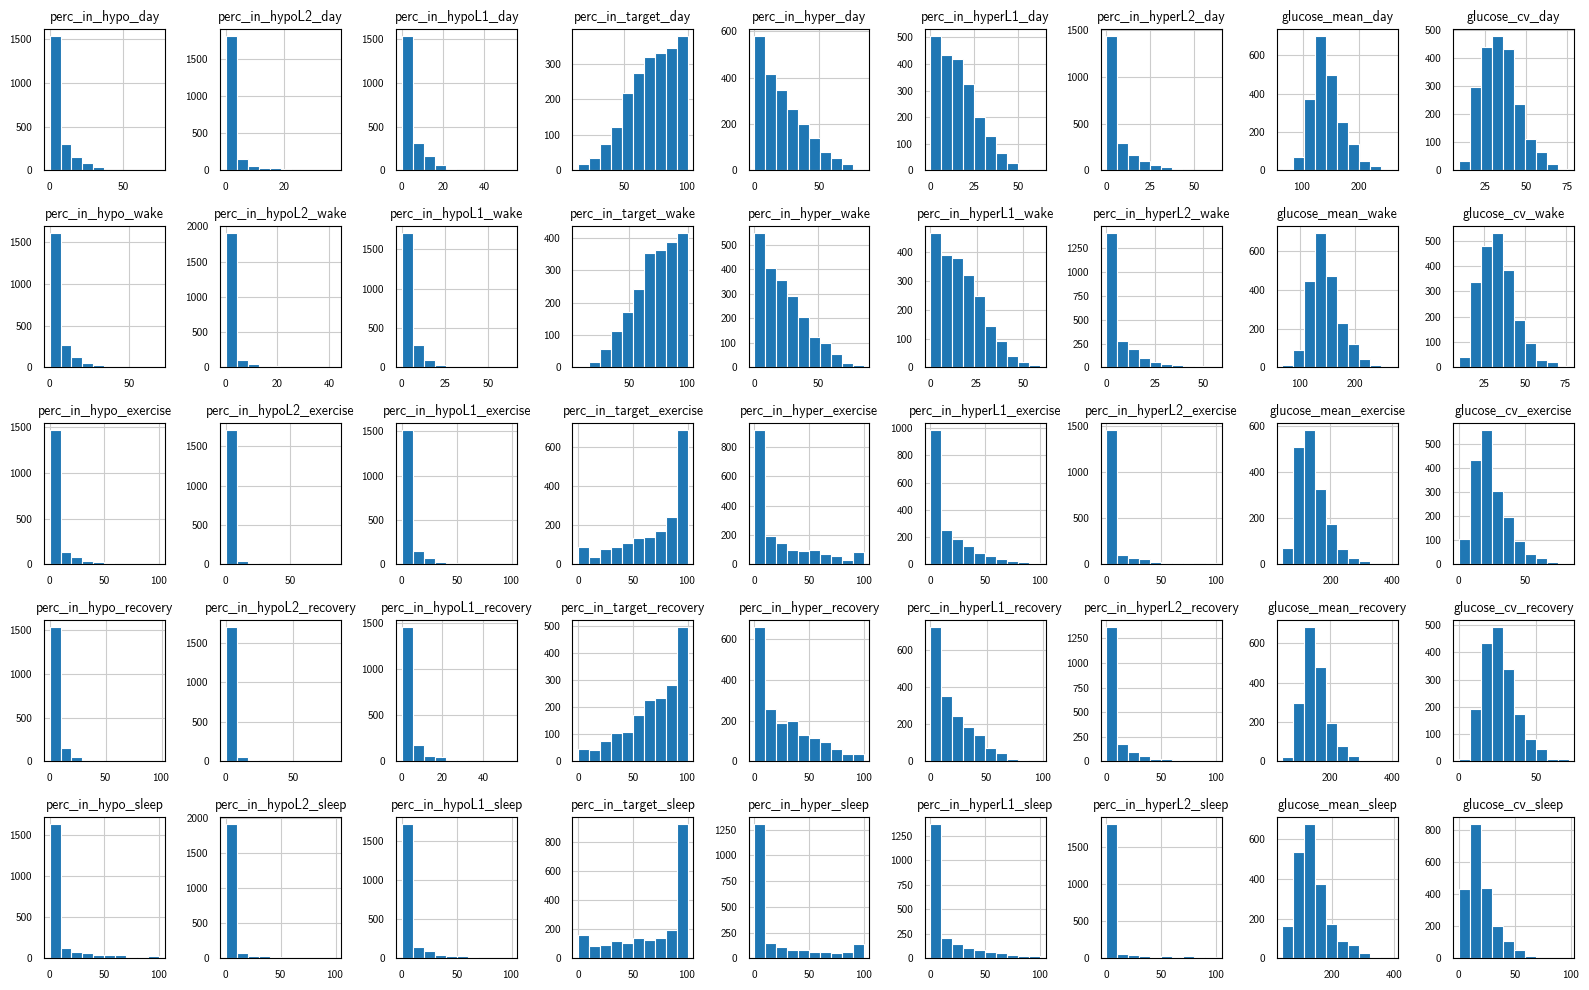

In [107]:
dc_agg.iloc[:, dc_agg.columns.str.startswith('perc_in_') | 
               dc_agg.columns.str.startswith('glucose_mean_') | 
               dc_agg.columns.str.startswith('glucose_cv_')].hist(figsize=(16,10), layout=(5,9))
plt.show()

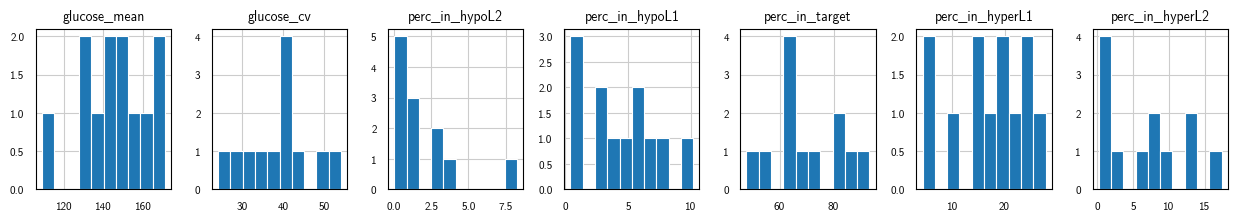

In [121]:
dc_rider = get_cgm_stats(dc)
dc_rider['day'].hist(figsize=(16,10), layout=(5,9))
plt.show()

#### One-sample t-test for comparison with clinical targets

In [152]:
from scipy.stats import ttest_1samp

In [126]:
targets = {'perc_in_hypoL2' : 1,
           'perc_in_hypoL1' : 3,
           'perc_in_target' : 70,
           'perc_in_hyperL1': 20,
           'perc_in_hyperL2': 5,
           'glucose_cv'     : 36}

In [151]:
for d, data in days.items():
    print(tnames[d])
    dc_rider = get_cgm_stats(data)
    tstats = {}
    for sec in stat_cols:
        res = {}
        for name, value in targets.items():
            t, p = ttest_1samp(dc_rider[sec][name], value)
            res[name] = [t, p]
        res = pd.DataFrame(res, index=['t', 'p']).T
        res['sign'] = res['p'].apply(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else '')))
        tstats[sec] = res
    display(pd.concat(tstats, axis=1))

All days (d=2115)


day                     wake                 exercise  \
                        t         p sign         t         p sign         t   
perc_in_hypoL2   1.445541  0.176187       0.917243  0.378687       0.468065   
perc_in_hypoL1   1.729350  0.111670       1.069435  0.307780       1.030578   
perc_in_target  -0.010616  0.991720       0.025443  0.980157       0.086302   
perc_in_hyperL1 -1.447103  0.175759      -1.006786  0.335671      -1.146174   
perc_in_hyperL2  1.065858  0.309324       1.125631  0.284282       1.420328   
glucose_cv       1.197657  0.256221       0.836261  0.420803       1.286370   

                                recovery                    sleep            \
                        p sign         t         p sign         t         p   
perc_in_hypoL2   0.648876       0.292815  0.775113       2.390730  0.035815   
perc_in_hypoL1   0.324867       0.263728  0.796865       2.499403  0.029538   
perc_in_target   0.932777      -0.495277  0.630150      -0.090607  0.929434   
perc_in_hyperL1  0.276045      -0.092997  0.927578      -2.391692  0.035754   
perc_in_hyperL2  0.183230       1.486005  0.165366       0.704961  0.495491   
glucose_cv       0.224729       0.245233  0.810791       1.545740  0.150436   

                      
                sign  
perc_in_hypoL2     *  
perc_in_hypoL1     *  
perc_in_target        
perc_in_hyperL1    *  
perc_in_hyperL2       
glucose_cv

Training days (d=1536)


day                     wake                 exercise  \
                        t         p sign         t         p sign         t   
perc_in_hypoL2   1.540479  0.151702       0.984993  0.345797       0.658413   
perc_in_hypoL1   1.992738  0.071690       1.374009  0.196788       1.442383   
perc_in_target   0.242054  0.813192       0.348299  0.734190       0.442766   
perc_in_hyperL1 -1.817385  0.096472      -1.468112  0.170079      -1.726744   
perc_in_hyperL2  0.741352  0.474010       0.754403  0.466451       0.965318   
glucose_cv       1.160339  0.270475       0.818935  0.430208       1.227840   

                                recovery                    sleep            \
                        p sign         t         p sign         t         p   
perc_in_hypoL2   0.523814       0.302868  0.767641       2.699889  0.020661   
perc_in_hypoL1   0.177057       0.347727  0.734608       2.555592  0.026728   
perc_in_target   0.666516      -0.332100  0.746056      -0.043702  0.965925   
perc_in_hyperL1  0.112151      -0.175365  0.863979      -2.254124  0.045559   
perc_in_hyperL2  0.355129       1.292148  0.222792       0.574706  0.577055   
glucose_cv       0.245133       0.060263  0.953027       1.422897  0.182502   

                      
                sign  
perc_in_hypoL2     *  
perc_in_hypoL1     *  
perc_in_target        
perc_in_hyperL1    *  
perc_in_hyperL2       
glucose_cv

Competition days (d=256)


day                     wake                 exercise  \
                        t         p sign         t         p sign         t   
perc_in_hypoL2   0.757434  0.466263       0.179971  0.860770      -6.160790   
perc_in_hypoL1   0.247005  0.809902      -0.779663  0.453646      -6.681502   
perc_in_target   0.017405  0.986456      -0.180375  0.860461      -2.443241   
perc_in_hyperL1 -0.862009  0.408878       0.039961  0.968910       2.793158   
perc_in_hyperL2  1.138535  0.281438       1.134949  0.282868       2.994174   
glucose_cv       0.418838  0.684189      -0.027072  0.978935      -1.011144   

                                recovery                    sleep            \
                        p sign         t         p sign         t         p   
perc_in_hypoL2   0.000107  *** -0.587222  0.570074       1.207196  0.255135   
perc_in_hypoL1   0.000055  *** -0.605052  0.558624       1.193174  0.260341   
perc_in_target   0.034656    * -0.720307  0.487831       0.327163  0.750290   
perc_in_hyperL1  0.019016    *  0.139222  0.892039      -2.618682  0.025656   
perc_in_hyperL2  0.013477    *  1.621780  0.135916       0.811158  0.436156   
glucose_cv       0.335787      -0.066090  0.948609       0.186229  0.855989   

                      
                sign  
perc_in_hypoL2        
perc_in_hypoL1        
perc_in_target        
perc_in_hyperL1    *  
perc_in_hyperL2       
glucose_cv

#### Independent t-test for comparison of training and competition days

In [153]:
from scipy.stats import ttest_ind

In [119]:
dc_comp = get_cgm_stats(dc[dc['race_day'] & dc['exercise_day']])
dc_train = get_cgm_stats(dc[~dc['race_day'] & dc['exercise_day']])
dc_train = dc_train.drop(9) # participant 9 did not have any races

In [120]:
ttest_rel(dc_comp['exercise']['glucose_mean'], dc_train['exercise']['glucose_mean'])

Ttest_relResult(statistic=6.5472908798083855, pvalue=6.495055953191426e-05)

In [117]:
dc_train['exercise']['glucose_mean']

RIDER
1     122.637363
2     122.759754
3     126.571413
4     113.913747
5     158.629676
6     163.736302
7     129.832891
8     141.580802
9     133.336844
10    182.973013
11    148.937594
12    145.131173
Name: glucose_mean, dtype: float64

In [118]:
dc_comp['exercise']['glucose_mean']

RIDER
1     156.698714
2     163.999079
3     151.675348
4     156.468914
5     173.356567
6     203.651316
7     176.888008
8     166.802083
10    179.130382
11    196.562314
12    170.584364
Name: glucose_mean, dtype: float64

Logistic regression (as a form of hierarchical unequal-sampled t-test)

In [107]:
from pymer4.models import Lmer

/local/home/evanweenen/.local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [171]:
df_stats = dc_agg.copy()
df_stats = df_stats[['RIDER', 'glucose_mean_day', 'glucose_mean_wake', 'glucose_mean_exercise', 
                     'glucose_mean_recovery', 'glucose_mean_sleep', 'race_day', 'exercise_day']]

In [172]:
model = Lmer('glucose_mean_exercise ~ 1+race_day + (1+race_day | RIDER)', 
             data=df_stats[df_stats['exercise_day']].dropna(subset=['glucose_mean_exercise']))
print(model.fit())

Formula: glucose_mean_exercise~1+race_day+(1+race_day|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 1788	 Groups: {'RIDER': 12.0}

Log-likelihood: -9315.565 	 AIC: 18631.131

Random effects:

                  Name       Var     Std
RIDER      (Intercept)   360.882  18.997
RIDER     race_dayTRUE   154.511  12.430
Residual                1927.081  43.899

               IV1           IV2   Corr
RIDER  (Intercept)  race_dayTRUE -0.638

Fixed effects:

              Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    140.653  129.613  151.694  5.633  10.931  24.969    0.0  ***
race_dayTRUE    35.115   25.442   44.787  4.935   8.370   7.116    0.0  ***


In [180]:
model.coefs

Estimate      2.5_ci     97.5_ci        SE         DF  \
(Intercept)   140.653411  129.612866  151.693956  5.633035  10.930516   
race_dayTRUE   35.114555   25.442477   44.786632  4.934824   8.369809   

                 T-stat         P-val  Sig  
(Intercept)   24.969385  5.453630e-11  ***  
race_dayTRUE   7.115665  8.029734e-05  ***

In [173]:
model.coefs[['Estimate', '2.5_ci', '97.5_ci']].style.format('{:.1f}')

In [174]:
model.coefs.loc['race_dayTRUE', ['Estimate', '2.5_ci', '97.5_ci']] / model.coefs.loc['(Intercept)', ['Estimate', '2.5_ci', '97.5_ci']]

Estimate    0.249653
2.5_ci      0.196296
97.5_ci     0.295243
dtype: object

In [175]:
model.coefs.loc['race_dayTRUE', ['Estimate', '2.5_ci', '97.5_ci']] / model.coefs.loc['(Intercept)', 'Estimate']

Estimate    0.249653
2.5_ci      0.180888
97.5_ci     0.318418
Name: race_dayTRUE, dtype: object

In [176]:
model.coefs.loc['race_dayTRUE', ['Estimate', '2.5_ci', '97.5_ci']] / model.coefs.loc['(Intercept)', '2.5_ci']

Estimate    0.270919
2.5_ci      0.196296
97.5_ci     0.345542
Name: race_dayTRUE, dtype: object

In [177]:
model.coefs.loc['race_dayTRUE', ['Estimate', '2.5_ci', '97.5_ci']] / model.coefs.loc['(Intercept)', '97.5_ci']

Estimate    0.231483
2.5_ci      0.167722
97.5_ci     0.295243
Name: race_dayTRUE, dtype: object

In [178]:
print("Increase of 25.0 [16.8-34.6]%")

Increase of 22.1 [14.6-31.0]%


In [181]:
model = Lmer('glucose_mean_recovery ~ 1+race_day + (1+race_day | RIDER)', 
             data=df_stats[df_stats['exercise_day']].dropna(subset=['glucose_mean_recovery']))
print(model.fit())

Formula: glucose_mean_recovery~1+race_day+(1+race_day|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 1786	 Groups: {'RIDER': 12.0}

Log-likelihood: -8955.895 	 AIC: 17911.790

Random effects:

                  Name       Var     Std
RIDER      (Intercept)   570.608  23.887
RIDER     race_dayTRUE   152.283  12.340
Residual                1293.680  35.968

               IV1           IV2   Corr
RIDER  (Intercept)  race_dayTRUE -0.504

Fixed effects:

              Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    151.208  137.533  164.882  6.977  10.914  21.672  0.000  ***
race_dayTRUE    12.329    3.292   21.367  4.611   7.861   2.674  0.029    *


In [182]:
model = Lmer('glucose_mean_sleep ~ 1+race_day + (1+race_day | RIDER)', 
             data=df_stats[df_stats['exercise_day']].dropna(subset=['glucose_mean_sleep']))
print(model.fit())

Formula: glucose_mean_sleep~1+race_day+(1+race_day|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 1782	 Groups: {'RIDER': 12.0}

Log-likelihood: -9473.947 	 AIC: 18947.894

Random effects:

                  Name       Var     Std
RIDER      (Intercept)   613.998  24.779
RIDER     race_dayTRUE   595.801  24.409
Residual                2366.803  48.650

               IV1           IV2   Corr
RIDER  (Intercept)  race_dayTRUE -0.282

Fixed effects:

              Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    137.746  123.447  152.044  7.295  11.027  18.881  0.000  ***
race_dayTRUE     3.664  -12.660   19.987  8.328  10.868   0.440  0.669     


In [118]:
model = Lmer('glucose ~ 1+sleep + (1+sleep | RIDER)', data=df_stats)
print(model.fit())

Formula: glucose~1+sleep+(1+sleep|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 574962	 Groups: {'RIDER': 12.0}

Log-likelihood: -3145796.189 	 AIC: 6291592.378

Random effects:

                 Name       Var     Std
RIDER     (Intercept)   329.354  18.148
RIDER       sleepTRUE   344.817  18.569
Residual               3309.174  57.525

               IV1        IV2   Corr
RIDER  (Intercept)  sleepTRUE -0.112

Fixed effects:

             Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)   147.320  137.050  157.590  5.240  11.003  28.115  0.000  ***
sleepTRUE      -8.581  -19.095    1.933  5.364  10.999  -1.600  0.138     


In [120]:
model = Lmer('glucose ~ 1+recovery + (1+recovery | RIDER)', data=df_stats[df_stats['exercise'] | df_stats['recovery']])
print(model.fit())

Formula: glucose~1+recovery+(1+recovery|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 161715	 Groups: {'RIDER': 12.0}

Log-likelihood: -887504.296 	 AIC: 1775008.591

Random effects:

                  Name       Var     Std
RIDER      (Intercept)   394.902  19.872
RIDER     recoveryTRUE   318.838  17.856
Residual                3420.031  58.481

               IV1           IV2   Corr
RIDER  (Intercept)  recoveryTRUE -0.235

Fixed effects:

              Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    145.606  134.351  156.861  5.742  10.999  25.357  0.000  ***
recoveryTRUE     7.447   -2.679   17.572  5.166  10.929   1.441  0.177     


In [122]:
model = Lmer('glucose ~ 1+recovery + (1+recovery | RIDER)', data=df_stats[(df_stats['exercise'] | df_stats['recovery']) & ~df_stats['race_day']])
print(model.fit())

Formula: glucose~1+recovery+(1+recovery|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 138127	 Groups: {'RIDER': 12.0}

Log-likelihood: -753357.924 	 AIC: 1506715.848

Random effects:

                  Name       Var     Std
RIDER      (Intercept)   404.940  20.123
RIDER     recoveryTRUE   296.275  17.213
Residual                3194.908  56.524

               IV1           IV2   Corr
RIDER  (Intercept)  recoveryTRUE -0.193

Fixed effects:

              Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    140.842  129.445  152.240  5.815  10.999  24.220   0.00  ***
recoveryTRUE    10.429    0.665   20.193  4.982  10.939   2.093   0.06    .


In [123]:
model = Lmer('glucose ~ 1+recovery + (1+recovery | RIDER)', data=df_stats[(df_stats['exercise'] | df_stats['recovery']) & df_stats['race_day']])
print(model.fit())

Formula: glucose~1+recovery+(1+recovery|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 23588	 Groups: {'RIDER': 11.0}

Log-likelihood: -131742.355 	 AIC: 263484.709

Random effects:

                  Name       Var     Std
RIDER      (Intercept)   262.831  16.212
RIDER     recoveryTRUE   316.099  17.779
Residual                4142.746  64.364

               IV1           IV2   Corr
RIDER  (Intercept)  recoveryTRUE -0.149

Fixed effects:

              Estimate   2.5_ci  97.5_ci     SE     DF  T-stat  P-val  Sig
(Intercept)    172.248  162.543  181.953  4.952  9.994  34.786  0.000  ***
recoveryTRUE   -11.049  -21.768   -0.330  5.469  9.549  -2.020  0.072    .


In [144]:
group = dc[dc['exercise_day'] & dc['sleep']].groupby(['RIDER','date'])
df_test = group.apply(stat_func).apply(pd.Series)
df_test = pd.merge(df_test, group['race_day'].first(), left_index=True, right_index=True, how='inner')
df_test = df_test.reset_index()
df_test

RIDER    date_6h  time_in_hypo_  time_in_hypoL2_  time_in_hypoL1_  \
0         1 2018-12-12              0                0                0   
1         1 2018-12-13              0                0                0   
2         1 2018-12-14              0                0                0   
3         1 2018-12-16              0                0                0   
4         1 2018-12-18              0                0                0   
...     ...        ...            ...              ...              ...   
1775     12 2019-10-19             37               35                2   
1776     12 2019-10-20              5                4                1   
1777     12 2019-10-21              0                0                0   
1778     12 2019-10-22              0                0                0   
1779     12 2019-10-23              0                0                0   

      time_in_target_  time_in_hyper_  time_in_hyperL1_  time_in_hyperL2_  \
0                  72               0                 0                 0   
1                  72               0                 0                 0   
2                  71               1                 1                 0   
3                  72               0                 0                 0   
4                  72               0                 0                 0   
...               ...             ...               ...               ...   
1775               46               4                 4                 0   
1776               54               5                 5                 0   
1777                0              13                 0                13   
1778                0              15                 0                15   
1779                3               7                 4                 3   

      glucose_mean_  ...  glucose_cv_  glucose_rate_  completeness_  count_  \
0         89.416667  ...     0.113830      89.416667            1.0      72   
1        114.263889  ...     0.167262     114.263889            1.0      72   
2        132.875000  ...     0.143178     132.875000            1.0      72   
3        102.805556  ...     0.062287     102.805556            1.0      72   
4        115.513889  ...     0.067167     115.513889            1.0      72   
...             ...  ...          ...            ...            ...     ...   
1775      86.793103  ...     0.587268      80.672479            1.0      87   
1776     134.953125  ...     0.298373     131.545573            1.0      64   
1777     382.538462  ...     0.057625     324.479290            1.0      13   
1778     394.200000  ...     0.032911     325.805458            1.0      15   
1779     244.500000  ...     0.442589     207.166667            1.0      10   

          LBGI_      HBGI_     AUC_  hypo_  hyper_  race_day_6h  
0      2.307075   0.000330   6339.0  False   False        False  
1      0.356689   0.531772   8099.5  False   False        False  
2      0.000089   1.497554   9415.0  False    True        False  
3      0.407505   0.010549   7292.5  False   False        False  
4      0.028667   0.142788   8191.5  False   False        False  
...         ...        ...      ...    ...     ...          ...  
1775  15.532898   1.334923  14793.0   True    True        False  
1776   2.013077   3.081664   9461.5   True    True        False  
1777   0.000000  53.045989   9365.5  False    True        False  
1778   0.000000  55.719709  16526.0  False    True        False  
1779   0.000000  22.456325   6400.5  False    True        False  

[1780 rows x 21 columns]

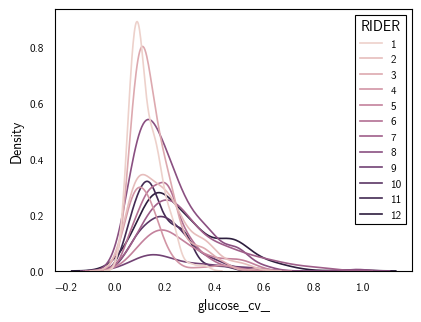

In [154]:
sns.kdeplot(x='glucose_cv_', data=df_test, hue='RIDER')
plt.show()
# TODO: we should check if this is the right test to do, what if you want to do a similar test to above but then for standard deviation?

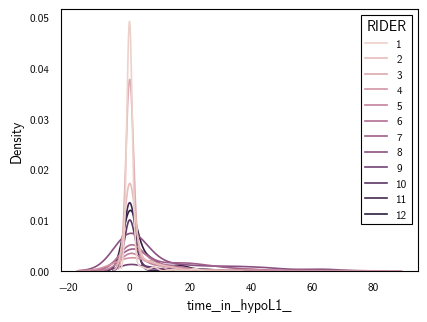

In [156]:
sns.kdeplot(x='time_in_hypoL1_', data=df_test, hue='RIDER')
plt.show()
# TODO: we should check if this is the right test to do, what if you want to do a similar test to above but then for standard deviation?

In [146]:
model = Lmer('glucose_cv_ ~ 1 + race_day + (1+race_day | RIDER)', data=df_test)
print(model.fit())

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: glucose_cv_~1+race_day_6h+(1+race_day_6h|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 1780	 Groups: {'RIDER': 12.0}

Log-likelihood: 1247.148 	 AIC: -2494.296

Random effects:

                     Name    Var    Std
RIDER         (Intercept)  0.003  0.057
RIDER     race_day_6hTRUE  0.001  0.029
Residual                   0.014  0.118

               IV1              IV2   Corr
RIDER  (Intercept)  race_day_6hTRUE -0.507

Fixed effects:

                 Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)         0.205   0.172    0.238  0.017  11.079  12.161  0.000  ***
race_day_6hTRUE    -0.002  -0.026    0.022  0.012  11.303  -0.157  0.878     


In [ ]:
from rpy2.robjects.packages import importr
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

base = importr('base')
stats = importr('stats')
lme4 = importr('lme4')

# TODO: standardize???

with localconverter(ro.default_converter + pandas2ri.converter):
    r_df_test = ro.conversion.py2rpy(df_test)

In [161]:
model = lme4.glmer('time_in_hypoL1_ ~ 1 + race_day + (1+race_day | RIDER)', data=r_df_test, family='poisson')
print(base.summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: time_in_hypoL1_ ~ 1 + race_day_6h + (1 + race_day_6h | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L,

In [160]:
model = lme4.glmer('time_in_hypoL2_ ~ 1 + race_day + (1+race_day | RIDER)', data=r_df_test, family='poisson')
print(base.summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: time_in_hypoL2_ ~ 1 + race_day_6h + (1 + race_day_6h | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L,

## Unused analyses

### Competition vs. training

### Glucose distribution (boxplots)

In [97]:
kws_box = {'race':	dict(boxprops=dict(color='w', facecolor=color_race['race'], hatch='\\\\\\'),
						 medianprops=dict(color='w', linewidth=2),
						 whiskerprops=dict(color=color_race['race']), capprops=dict(color=color_race['race'])),
		   'train':dict(boxprops=dict(color='w', facecolor=color_race['train'], hatch='///'),
						 medianprops=dict(color='w', linewidth=2),
						 whiskerprops=dict(color=color_race['train']), capprops=dict(color=color_race['train']))}

All, stratify: sections

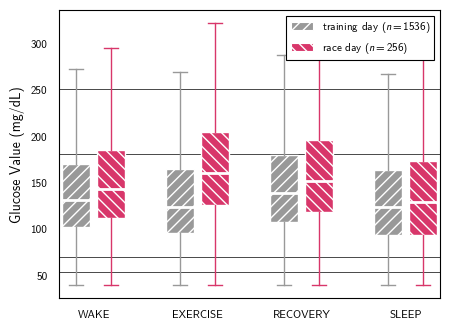

In [98]:
n_nc = len(dc.loc[~dc['race_day'] & dc['exercise_day'], ['RIDER', 'date']].drop_duplicates())
n_rc = len(dc.loc[dc['race_day'] & dc['exercise_day'], ['RIDER', 'date']].drop_duplicates())

fig, ax = plt.subplots()

# grid in plot
for _, l in list(glucose_levels.items())[1:]:
    ax.axhline(l[0], color='k', linewidth=.5, zorder=1)
    
for k, sec in enumerate(SECTIONS):
	plt.boxplot(dc.loc[dc[sec] & ~dc['race_day'] & dc['exercise_day'], COL], positions=[k+0.5+k*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['train'])
	plt.boxplot(dc.loc[dc[sec] & dc['race_day'] & dc['exercise_day'], COL], positions=[k+1.5+k*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['race'])
plt.xticks([1,4,7,10], SECTIONS)
plt.ylabel(COL)
plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
					Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
			loc='upper right')
ax.set_xticklabels([sec.upper() for sec in SECTIONS])
savefig('boxplot/box_glucose_sections')

Individual athletes, stratify: sections

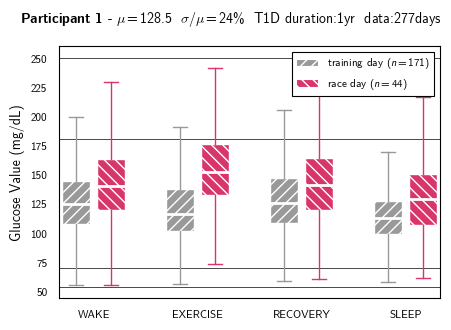

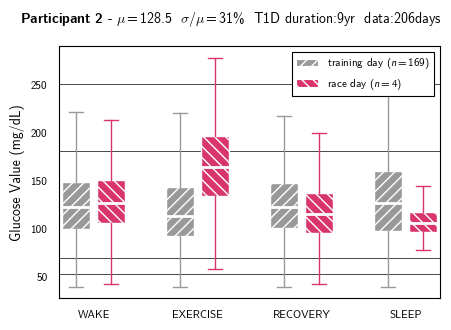

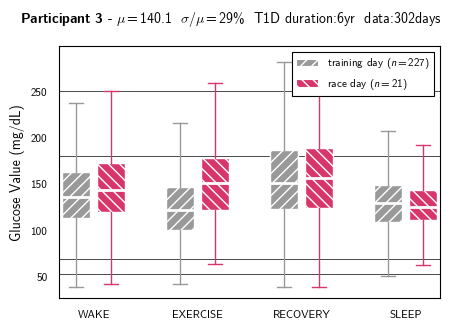

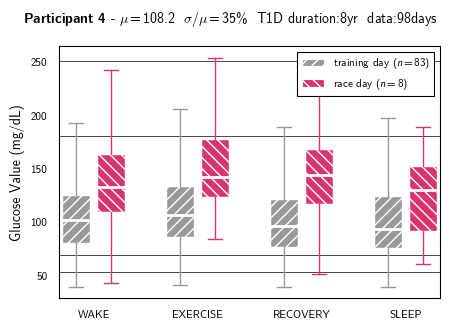

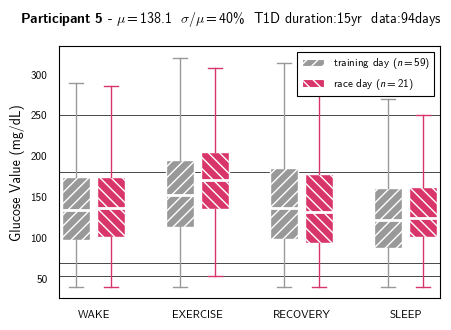

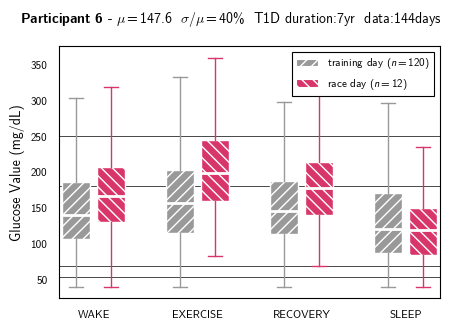

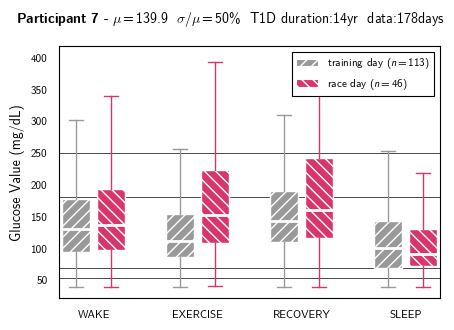

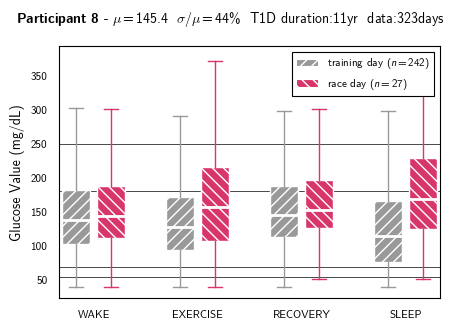

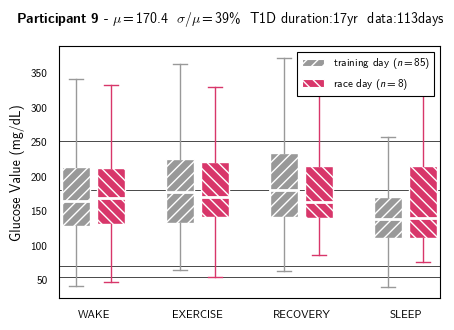

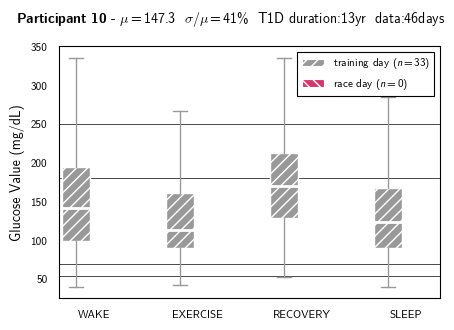

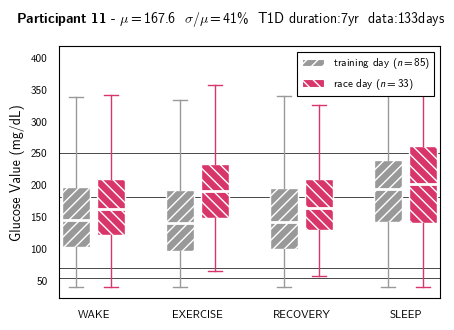

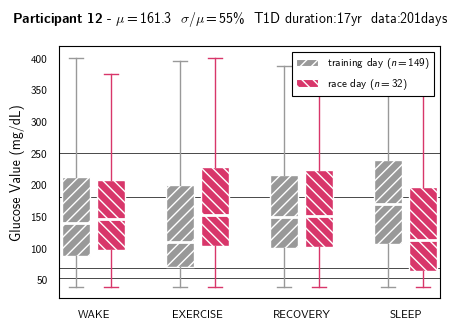

In [99]:
for i in ATHLETES:
    n_nc = len(dc.loc[(dc.RIDER == i) & ~dc['race_day'] & dc['exercise_day'], 'date'].unique())
    n_rc = len(dc.loc[(dc.RIDER == i) & dc['race_day'] & dc['exercise_day'], 'date'].unique())

    fig, ax = plt.subplots()

    # grid in plot
    for _, l in list(glucose_levels.items())[1:]:
        ax.axhline(l[0], color='k', linewidth=.5, zorder=1)

    for k, sec in enumerate(SECTIONS):
        plt.boxplot(dc.loc[(dc.RIDER == i) & dc[sec] & ~dc['race_day'] & dc['exercise_day'], COL], positions=[k+0.5+k*2], widths=[0.8],
            patch_artist=True, showfliers=False, **kws_box['train'])
        plt.boxplot(dc.loc[(dc.RIDER == i) & dc[sec] & dc['race_day'] & dc['exercise_day'], COL], positions=[k+1.5+k*2], widths=[0.8],
            patch_artist=True, showfliers=False, **kws_box['race'])
    plt.xticks([1,4,7,10], SECTIONS)
    plt.ylabel(COL)
    plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
                        Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
                loc='upper right')

    title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
        .format(dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean(),
                dc[(dc.RIDER == i) & dc['exercise_day']][COL].std()/dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean()*100,
                info.loc[i, 'diabetes_duration'],
                len(dc_agg[dc_agg.RIDER == i]))
    ax.set_xticklabels([sec.upper() for sec in SECTIONS])
    savefig(path='boxplot/box_glucose_sections', i=i, title=title, x=0.45, y=1.06)

All, stratify: athletes

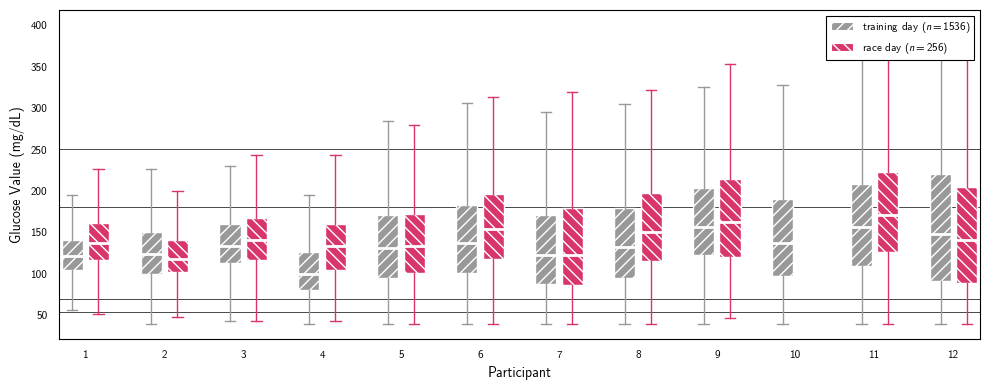

In [100]:
n_nc = len(dc.loc[~dc['race_day'] & dc['exercise_day'], ['RIDER', 'date']].drop_duplicates())
n_rc = len(dc.loc[dc['race_day'] & dc['exercise_day'], ['RIDER', 'date']].drop_duplicates())

# hue: athlete
fig, ax = plt.subplots(figsize=(10,4))

# grid in plot
for _, l in list(glucose_levels.items())[1:]:
    ax.axhline(l[0], color='k', linewidth=.5, zorder=1)

for n, i in enumerate(ATHLETES):
	plt.boxplot(dc.loc[(dc.RIDER == i) & ~dc['race_day'] & dc['exercise_day'], COL], positions=[n+0.5+n*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['train'])
	plt.boxplot(dc.loc[(dc.RIDER == i) & dc['race_day'] & dc['exercise_day'], COL], positions=[n+1.5+n*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['race'])
plt.ylabel(COL) ; plt.xlabel('Participant')
plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
					Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
			loc='upper right')
plt.xticks(np.arange(1, len(ATHLETES)*3,3), ATHLETES)

savefig('boxplot/box_glucose_riders', xticks=ax)

### Glucose during cycling (longitudinal)

In [87]:
# session id
dc['tid'] = dc.loc[dc['exercise'] != dc['exercise'].shift(), 'exercise'].cumsum()
dc['tid'] = dc['tid'].fillna(method='ffill')

# time within session
dc['t'] = dc.groupby('tid').cumcount() * 5
dc

RIDER           timestamp  Glucose Value (mg/dL)     local_timestamp  \
0            8 2018-11-05 05:00:00                   73.0 2018-11-05 06:00:00   
1            8 2018-11-05 05:05:00                   73.0 2018-11-05 06:05:00   
2            8 2018-11-05 05:10:00                   73.0 2018-11-05 06:10:00   
3            8 2018-11-05 05:15:00                   73.0 2018-11-05 06:15:00   
4            8 2018-11-05 05:20:00                   73.0 2018-11-05 06:20:00   
...        ...                 ...                    ...                 ...   
1267159      9 2019-01-27 04:35:00                   70.0 2019-01-27 05:35:00   
1267160      9 2019-01-27 04:40:00                   72.0 2019-01-27 05:40:00   
1267161      9 2019-01-27 04:45:00                   73.0 2019-01-27 05:45:00   
1267162      9 2019-01-27 04:50:00                   54.0 2019-01-27 05:50:00   
1267163      9 2019-01-27 04:55:00                   69.0 2019-01-27 05:55:00   

         exercise  recovery   wake  sleep  race_day  travel_day       date  \
0           False     False   True  False     False       False 2018-11-05   
1           False     False   True  False     False       False 2018-11-05   
2           False     False   True  False     False       False 2018-11-05   
3           False     False   True  False     False       False 2018-11-05   
4           False     False   True  False     False       False 2018-11-05   
...           ...       ...    ...    ...       ...         ...        ...   
1267159     False     False  False   True     False       False 2019-01-27   
1267160     False     False  False   True     False       False 2019-01-27   
1267161     False     False  False   True     False       False 2019-01-27   
1267162     False     False  False   True     False       False 2019-01-27   
1267163     False     False  False   True     False       False 2019-01-27   

         exercise_day    date_6h  race_day_6h  travel_day_6h  exercise_day_6h  \
0                True 2018-11-05        False          False             True   
1                True 2018-11-05        False          False             True   
2                True 2018-11-05        False          False             True   
3                True 2018-11-05        False          False             True   
4                True 2018-11-05        False          False             True   
...               ...        ...          ...            ...              ...   
1267159          True 2019-01-26        False          False             True   
1267160          True 2019-01-26        False          False             True   
1267161          True 2019-01-26        False          False             True   
1267162          True 2019-01-26        False          False             True   
1267163          True 2019-01-26        False          False             True   

         completeness     tid     t  
0            0.920139     0.0     0  
1            0.920139     0.0     5  
2            0.920139     0.0    10  
3            0.920139     0.0    15  
4            0.920139     0.0    20  
...               ...     ...   ...  
1267159      0.961806  1971.0  1135  
1267160      0.961806  1971.0  1140  
1267161      0.961806  1971.0  1145  
1267162      0.961806  1971.0  1150  
1267163      0.961806  1971.0  1155  

[574962 rows x 19 columns]

All

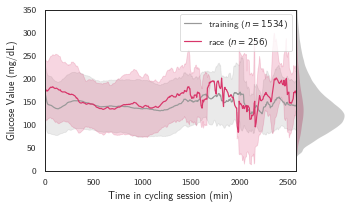

In [90]:
n_nc = len(dc.loc[~dc['race_day'] & dc['exercise_day'], ['RIDER', 'date']].drop_duplicates())
n_rc = len(dc.loc[dc['race_day'] & dc['exercise_day'], ['RIDER', 'date']].drop_duplicates())

t_max = dc.groupby('tid')['t'].max().quantile(0.9) #dc['t'].max()

fig, ax = plt.subplots(1,2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)
sns.lineplot(data = dc[dc['exercise_day']], x='t', y=COL, hue='race_day', ci='sd', palette=list(color_race.values()), ax=ax[0])
ax[0].set_xlabel('Time in cycling session (min)')
ax[0].legend(loc='upper right', handles=ax[0].get_legend().get_lines(), 
	labels=['training'+r' ($n = {:.0f}$)'.format(n_nc), 'race'+r' ($n = {:.0f}$)'.format(n_rc)])
sns.kdeplot(data=dc.loc[dc['t'].notna() & dc['exercise_day']], y=COL, hue='race_day', ax=ax[1],
	fill=True, alpha=.5, palette=list(color_race.values()), linewidth=0, legend=False)
sns.despine(bottom=True, right=True, top=True, ax=ax[1])
ax[1].set(xlabel=None, xticks=[])
plt.ylim((0,350))
ax[0].set_xlim((0, t_max))
savefig('time_cycling/glucose_cycling')

Individual athletes

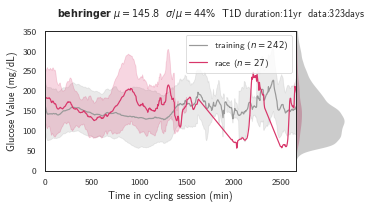

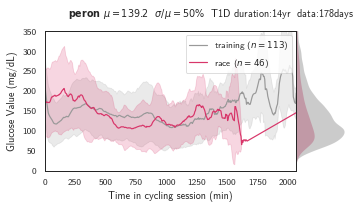

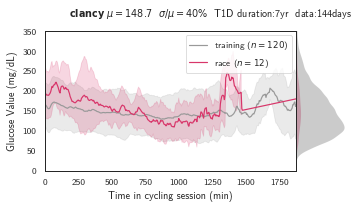

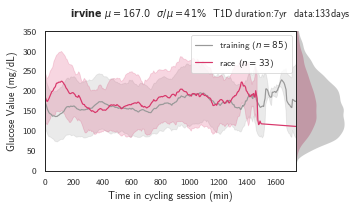

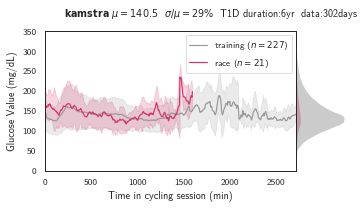

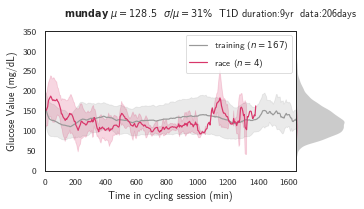

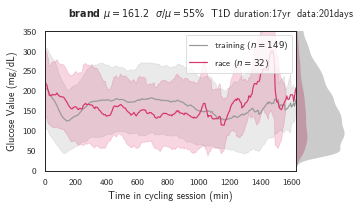

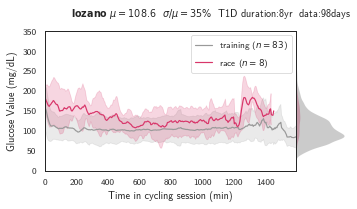

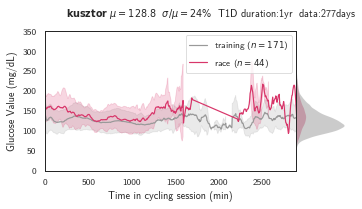

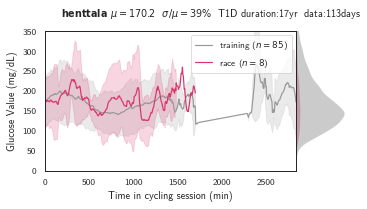

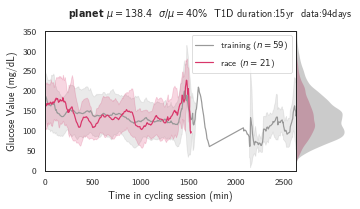

In [93]:
for i in dc[dc['race_day']].RIDER.unique():
	n_nc = len(dc.loc[(dc.RIDER == i) & ~dc['race_day'] & dc['exercise_day'], 'date'].unique())
	n_rc = len(dc.loc[(dc.RIDER == i) & dc['race_day'] & dc['exercise_day'], 'date'].unique())

	t_max = dc[dc.RIDER == i].groupby('tid')['t'].max().quantile(0.9)#dc.loc[dc.RIDER == i, 't'].max()

	fig, ax = plt.subplots(1,2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)
	sns.lineplot(data=dc[(dc.RIDER == i) & dc['exercise_day']], x='t', y=COL, ci='sd', hue='race_day', palette=list(color_race.values()), ax=ax[0])
	ax[0].set_xlabel('Time in cycling session (min)')
	ax[0].legend(loc='upper right', handles=ax[0].get_legend().get_lines(),
		labels=['training'+r' ($n = {:.0f}$)'.format(n_nc), 'race'r' ($n = {:.0f}$)'.format(n_rc)])
	sns.kdeplot(data=dc.loc[dc['t'].notna() & (dc.RIDER == i) & dc['exercise_day']], y=COL, hue='race_day', ax=ax[1],
		fill=True, alpha=.5, palette=list(color_race.values()), linewidth=0, legend=False)
	sns.despine(bottom=True, right=True, top=True, ax=ax[1])
	ax[1].set(xlabel=None, xticks=[])
	plt.ylim((0,350))
	ax[0].set_xlim((0, t_max))
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean(),
				dc[(dc.RIDER == i) & dc['exercise_day']][COL].std()/dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg[dc_agg.RIDER == i]))
	savefig(path='time_cycling/glucose_cycling', i=i, title=title, x=-1.7, y=1.06)

### Glucose during day

In [89]:
dc['time'] = timestamp_to_seconds(dc['local_timestamp'])

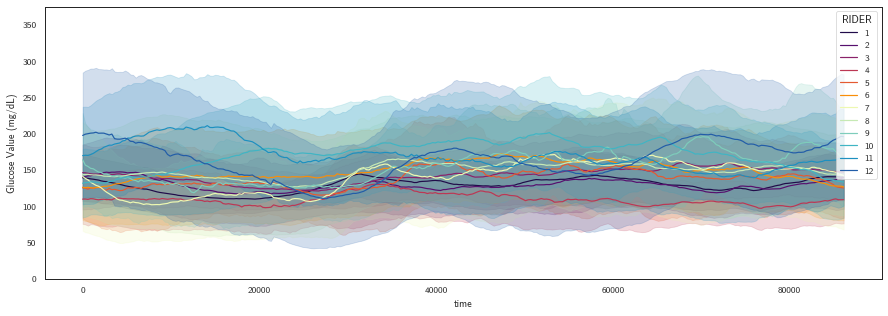

In [90]:
plt.figure(figsize=(15,5))
sns.lineplot(data=dc, x='time', y=COL, ci='sd', hue='RIDER', palette=palette_ath)
plt.ylim((0,375))
plt.show()

### Days with hypo events (during sections)

In [104]:
dc_agg = dc_agg.set_index(['RIDER', 'date'])

In [ ]:
dc_hypo = {}
for sec in SECTIONS+('1d',):
    dc_hypo[sec] = dc_agg['hypo_'+sec].groupby('RIDER').apply(lambda x: x.sum()/len(x))
dc_hypo = pd.concat(dc_hypo, axis=1) * 100
dc_hypo = dc_hypo.rename(columns={'1d':'total'})

In [82]:
dc_hyper = {}
for sec in SECTIONS+('1d',):
    dc_hyper[sec] = dc_agg['hyper_'+sec].groupby('RIDER').apply(lambda x: x.sum()/len(x))
dc_hyper = pd.concat(dc_hyper, axis=1) * 100
dc_hyper = dc_hyper.rename(columns={'1d':'total'})

Text(0.5, 1.0, 'Days in hyperglycemia')

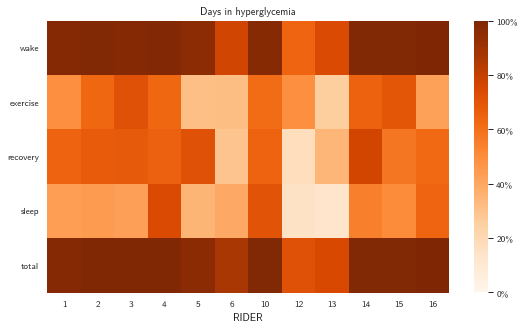

In [83]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(dc_hyper.T, vmin=0, vmax=100, cmap='Oranges')
fig.get_axes()[1].set_yticks(np.arange(0,101,20), ["{:.0f}%".format(j) for j in np.arange(0,101,20)])
plt.yticks(rotation=0)
plt.title("Days in hyperglycemia")

Text(0.5, 1.0, 'Days in hypoglycemia')

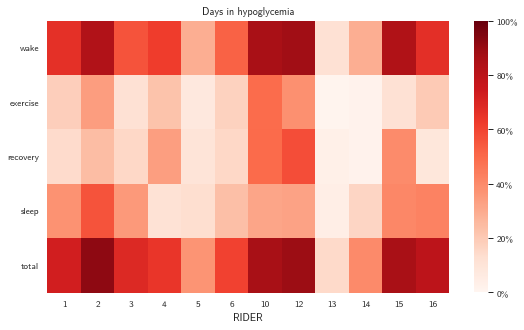

In [84]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(dc_hypo.T, vmin=0, vmax=100, cmap='Reds')
fig.get_axes()[1].set_yticks(np.arange(0,101,20), ["{:.0f}%".format(j) for j in np.arange(0,101,20)])

plt.yticks(rotation=0)
plt.title("Days in hypoglycemia")

In [85]:
dc_events = {}
for sec in SECTIONS+('1d',):
    dc_events[sec] = dc_agg[['time_in_hypo_'+sec, 'time_in_hyper_'+sec]].div(dc_agg['count_'+sec], axis=0)
    dc_events[sec].columns = ['_'.join(col.split('_')[:-1]) for col in dc_events[sec].columns]
    dc_events[sec] *= 100
    dc_events[sec] = dc_events[sec].sort_index(level=1)
    mask = (dc_events[sec]['time_in_hypo'] != 0) & (dc_events[sec]['time_in_hyper'] != 0)
    dc_events[sec].loc[mask, 'time_in_both'] = dc_events[sec]['time_in_hypo'] + dc_events[sec]['time_in_hyper']
    dc_events[sec].loc[mask, ['time_in_hypo', 'time_in_hyper']] = 0
    dc_events[sec] = dc_events[sec].replace({0:np.nan})

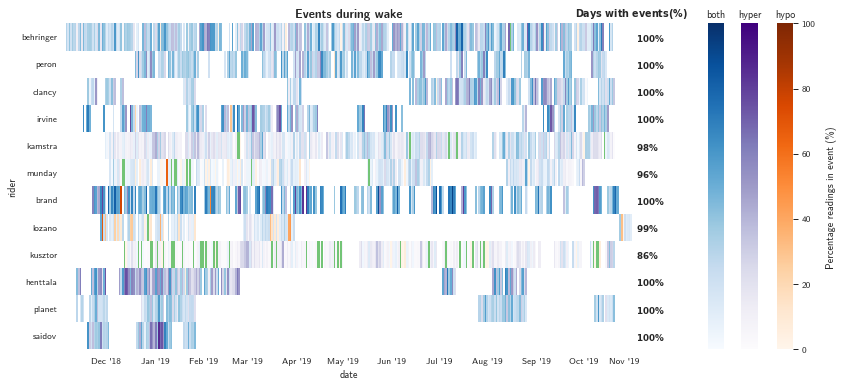

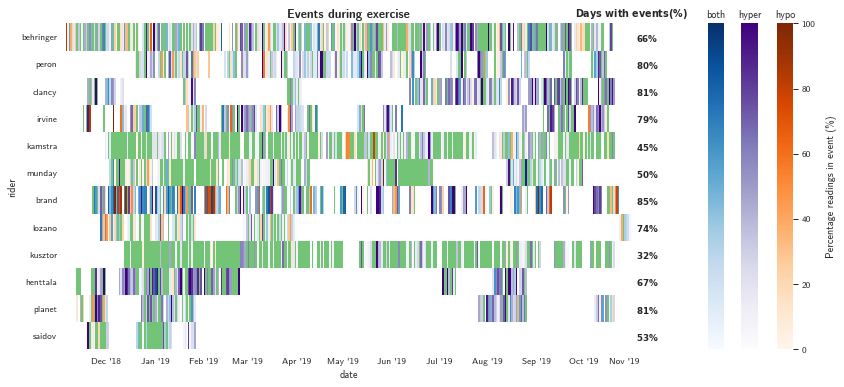

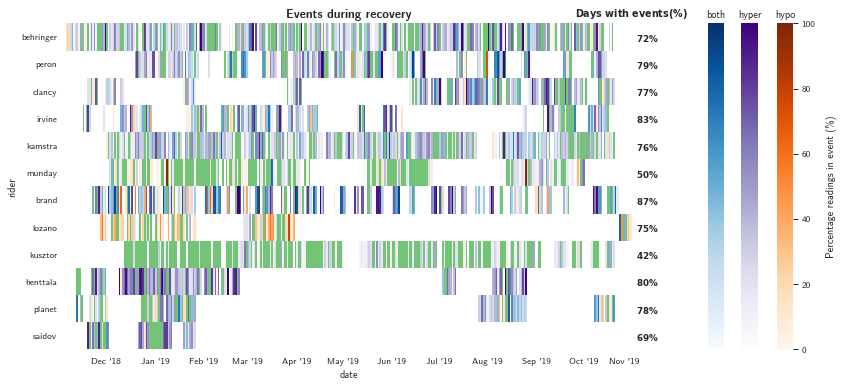

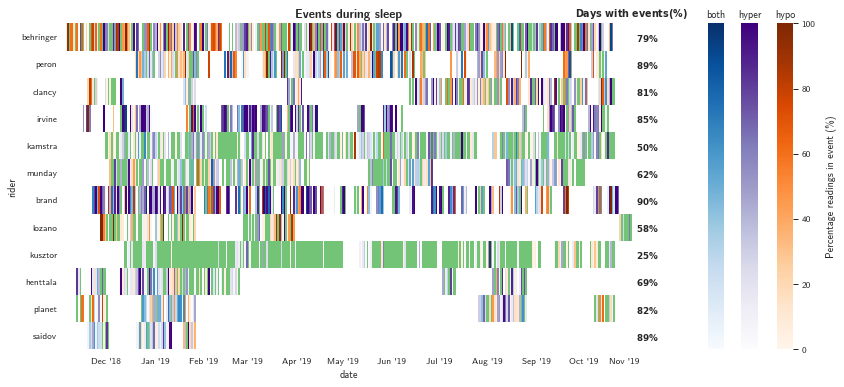

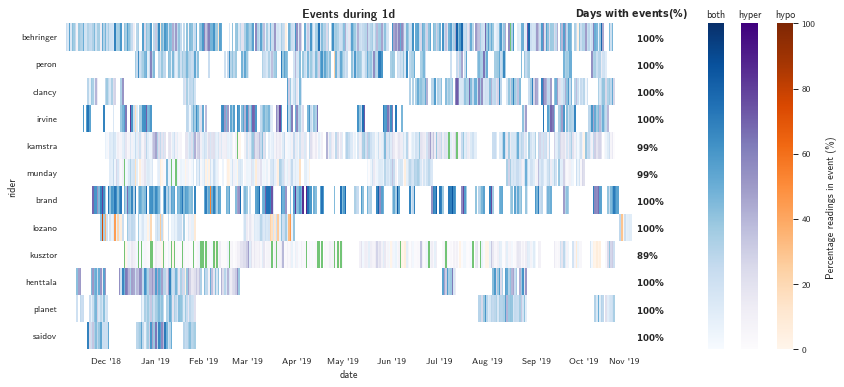

In [86]:
EVENTS = {'hypo': {'cmap':'Oranges', 'cbar_kws':{'pad':-0.1}},
          'hyper':{'cmap':'Purples', 'cbar_kws':{'pad':-0.1}}, 
          'both': {'cmap':'Blues'  , 'cbar_kws':{'pad':0.1}}}
for sec in SECTIONS+('1d',):
    fig, ax = plt.subplots(figsize=(15,6))
    
    df_avail = dc_events[sec].isna().all(axis=1).astype(float).unstack()
    sns.heatmap(df_avail, ax=ax, vmin=0, vmax=2, cmap='Greens', cbar=False)
    for event, kwargs in EVENTS.items():
        df_avail = dc_events[sec]['time_in_'+event].unstack()
        sns.heatmap(df_avail, ax=ax, vmin=0, vmax=100, **kwargs)
    
    # percentage columns
    perc_events = dc_events[sec].unstack().count(axis=1)/\
        dc_events[sec].reset_index().groupby('RIDER')['date'].count()*100
    ax2 = ax.secondary_yaxis("right")
    ax2.set_yticks(np.arange(len(df_avail.index))+0.5)
    ax2.set_yticklabels([r"$\bf{:.0f}\%$".format(i) for i in perc_events])
    ax2.tick_params(axis='y', length=0)
    ax2.spines['right'].set_visible(False)
    ax.text(0.9, 1.02, r'$\bf{:s}$'.format('Days\ with\ events (\%)'), ha='left', transform=ax.transAxes) 
    
    # colorbar
    for j, cbar_ax in enumerate(fig.get_axes()[1:]):
        if j != 0:
            cbar_ax.set_yticks([]) ; cbar_ax.set_yticklabels([])
        cbar_ax.set_title(list(EVENTS.keys())[j])
        if j == 0:
            cbar_ax.text(3, dc_events[sec].max().max()/2, 'Percentage readings in event (%)', va='center', rotation=90)
            
    monthyear = df_avail.columns.strftime("%b '%y")
    ticksloc = np.where(monthyear.to_series().shift() != monthyear.to_series())[0][1:]
    plt.xticks(ticks=ticksloc, labels=monthyear[ticksloc], rotation=0)
    plt.xlabel('date')
    plt.ylabel('rider')
    plt.title('Events during '+sec, fontweight='bold', fontsize=12)
    savefig('events/events', i=sec, yticks=ax)

Sign test

In [210]:
from statsmodels.stats.descriptivestats import sign_test

In [211]:
def get_signtest_per_sec(dc, mask):
    targets = {'time_in_hypoL2' : 1,
               'time_in_hypoL1' : 3,
               'time_in_target' : 70,
               'time_in_hyperL1': 20,
               'time_in_hyperL2': 5,
               'glucose_cv'     : 36}
    
    stats = get_complete_stats(dc[mask])

    return pd.DataFrame({k: sign_test(stats[k], v) for k, v in targets.items()}).T

In [212]:
def get_signtest(dc):
    res = pd.concat({**{'all': get_signtest_per_sec(dc, [True]*len(dc))}, 
              **{sec  : get_signtest_per_sec(dc, dc[sec]) for sec in SECTIONS}})
    res['sign.'] = res[1].apply(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else '')))
    res = res.unstack(level=0)
    res.columns = res.columns.swaplevel(0,1)
    res = res.sort_index(axis=1, key=lambda x: x.map({**{'all':0}, **{s: i+1 for i, s in enumerate(SECTIONS)}}))
    res = res.rename(columns={0:'M', 1:'p'})
    return res

In [213]:
from IPython.display import display
for d, df in days.items():
    display(d, get_signtest(df))

'all'

all                 wake                 exercise            \
                   M         p sign.    M         p sign.        M         p   
time_in_hypoL2   1.0  0.774414       -1.0  0.774414           -3.0  0.145996   
time_in_hypoL1   2.0  0.387695        2.0  0.387695            1.0  0.774414   
time_in_target  -1.0  0.774414       -1.0  0.774414            1.0  0.774414   
time_in_hyperL1 -1.0  0.774414       -1.0  0.774414           -2.0  0.387695   
time_in_hyperL2  1.0  0.774414        1.0  0.774414            2.0  0.387695   
glucose_cv       2.0  0.387695        2.0  0.387695            1.0  0.774414   

                      recovery                 sleep                  
                sign.        M         p sign.     M         p sign.  
time_in_hypoL2            -2.0  0.387695         2.0  0.387695        
time_in_hypoL1            -2.0  0.387695         2.0  0.387695        
time_in_target            -3.0  0.145996         1.0  0.774414        
time_in_hyperL1            2.0  0.387695        -4.0  0.038574     *  
time_in_hyperL2            1.0  0.774414        -1.0  0.774414        
glucose_cv                -1.0  0.774414         3.0  0.145996

'race'

all                 wake                 exercise            \
                   M         p sign.    M         p sign.        M         p   
time_in_hypoL2  -2.5  0.226562       -2.5  0.226562           -4.5  0.011719   
time_in_hypoL1  -0.5  1.000000       -1.5  0.548828           -4.5  0.011719   
time_in_target  -0.5  1.000000       -0.5  1.000000           -2.5  0.226562   
time_in_hyperL1 -1.5  0.548828       -1.5  0.548828            2.5  0.226562   
time_in_hyperL2  0.5  1.000000        0.5  1.000000            3.5  0.065430   
glucose_cv       1.5  0.548828        0.5  1.000000           -2.5  0.226562   

                      recovery                 sleep                  
                sign.        M         p sign.     M         p sign.  
time_in_hypoL2      *     -2.5  0.226562        -0.5  1.000000        
time_in_hypoL1      *     -1.5  0.548828        -0.5  1.000000        
time_in_target            -2.5  0.226562         0.5  1.000000        
time_in_hyperL1            0.5  1.000000        -3.5  0.065430        
time_in_hyperL2            0.5  1.000000        -1.5  0.548828        
glucose_cv                -0.5  1.000000        -0.5  1.000000

'train'

all                 wake                 exercise            \
                   M         p sign.    M         p sign.        M         p   
time_in_hypoL2   1.0  0.774414       -1.0  0.774414           -3.0  0.145996   
time_in_hypoL1   2.0  0.387695        2.0  0.387695            1.0  0.774414   
time_in_target  -1.0  0.774414       -1.0  0.774414            1.0  0.774414   
time_in_hyperL1 -1.0  0.774414       -2.0  0.387695           -2.0  0.387695   
time_in_hyperL2  1.0  0.774414        1.0  0.774414            2.0  0.387695   
glucose_cv       2.0  0.387695        2.0  0.387695            1.0  0.774414   

                      recovery                 sleep                  
                sign.        M         p sign.     M         p sign.  
time_in_hypoL2            -2.0  0.387695         2.0  0.387695        
time_in_hypoL1            -2.0  0.387695         2.0  0.387695        
time_in_target            -2.0  0.387695         0.0  1.000000        
time_in_hyperL1            2.0  0.387695        -4.0  0.038574     *  
time_in_hyperL2            2.0  0.387695        -1.0  0.774414        
glucose_cv                -1.0  0.774414         2.0  0.387695

$\chi^2$ test